In [52]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

In [53]:
# Combine classes
dataset['combined_labels'] = dataset['labels'].apply(lambda x: 'land' if x in ['rock', 'ice', 'freshwater'] else ('walrus' if x in ['walrus_pure', 'walrus_mixed'] else x))
combined_le = LabelEncoder()
dataset['combined_encoded_labels'] = combined_le.fit_transform(dataset['combined_labels'])

# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, label_col='combined_encoded_labels', test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df[label_col]):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df[label_col].values for cls in [combined_le.transform(['walrus'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset, label_col='combined_encoded_labels')
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, train_df['combined_encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, test_df['combined_encoded_labels'].values

In [54]:
# Train the binary classifier (ocean vs. not ocean)
binary_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

binary_model.fit(X_train, y_train)

# Save the binary model
binary_model_filename = "binary_ocean_not_ocean_model.joblib"
joblib.dump(binary_model, binary_model_filename)

['binary_ocean_not_ocean_model.joblib']

In [55]:
# Filter land and walrus pixels
not_ocean_mask = train_df['combined_labels'] == 'land'
X_train_not_ocean = X_train[not_ocean_mask]
y_train_not_ocean = train_df.loc[not_ocean_mask, 'encoded_labels'].values

# Train the classifier for walrus vs. land
walrus_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
], voting='soft')

walrus_model.fit(X_train_not_ocean, y_train_not_ocean)
joblib.dump(walrus_model, "walrus_vs_land_model.joblib")

# Save the walrus model
walrus_model_filename = "walrus_vs_land_model.joblib"
joblib.dump(walrus_model, walrus_model_filename)

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [06:08:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['walrus_vs_land_model.joblib']

In [56]:
# Post-processing functions to remove speckles
def connected_component_analysis(prediction, min_size=50):
    labeled_array, num_features = label(prediction)
    sizes = np.bincount(labeled_array.ravel())
    mask_sizes = sizes >= min_size
    mask_sizes[0] = 0
    cleaned_prediction = mask_sizes[labeled_array]
    return cleaned_prediction

def proximity_filter(prediction, ocean_mask, radius=30):
    structure = np.ones((2*radius+1, 2*radius+1), dtype=bool)
    if ocean_mask.ndim == 2:
        dilated_ocean = binary_dilation(ocean_mask, structure=structure)
    else:
        raise ValueError("ocean_mask must be a 2D array")
    
    walrus_mask = prediction == combined_le.transform(['walrus'])[0]
    walrus_mask[~dilated_ocean] = False
    prediction[walrus_mask] = combined_le.transform(['walrus'])[0]
    prediction[(prediction == combined_le.transform(['walrus'])[0]) & (~walrus_mask)] = combined_le.transform(['land'])[0]
    return prediction

def post_process_prediction(prediction, original_shape):
    prediction = prediction.reshape(original_shape)
    ocean_mask = prediction == combined_le.transform(['ocean'])[0]
    land_mask = prediction == combined_le.transform(['land'])[0]

    ocean_mask = connected_component_analysis(ocean_mask)
    land_mask = connected_component_analysis(land_mask)

    prediction[ocean_mask] = combined_le.transform(['ocean'])[0]
    prediction[land_mask] = combined_le.transform(['land'])[0]

    prediction = proximity_filter(prediction, ocean_mask)

    return prediction

# Function to predict classes for a given image
def predict_image(image_path, ocean_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        original_shape = (src.height, src.width)
        num_pixels = src.height * src.width

        image_ocean = image[3:].reshape((image.shape[0]-3, -1)).T
        image_walrus = image[:5].reshape((5, -1)).T

        ocean_predictions = ocean_model.predict(image_ocean)
        land_mask = ocean_predictions != combined_le.transform(['ocean'])[0]

        walrus_predictions = np.zeros_like(ocean_predictions)
        walrus_predictions[land_mask] = walrus_model.predict(image_walrus[land_mask])

        combined_predictions = np.where(land_mask, walrus_predictions, ocean_predictions)
        
        # Ensure combined_predictions matches the original number of pixels
        if combined_predictions.size != num_pixels:
            raise ValueError(f"Combined predictions size {combined_predictions.size} does not match the number of pixels {num_pixels}")

        combined_predictions = post_process_prediction(combined_predictions, original_shape)

        return combined_predictions

In [57]:
# Evaluate the models on the test set
y_pred_ocean = binary_model.predict(X_test_ocean)

# Create a mask for non-ocean samples in the test set
non_ocean_mask_test = y_test != combined_le.transform(['ocean'])[0]

# Predict walrus vs land only for non-ocean samples
y_pred_walrus = walrus_model.predict(X_test_walrus[non_ocean_mask_test])

# Combine predictions
y_pred_combined = y_pred_ocean.copy()
y_pred_combined[non_ocean_mask_test] = y_pred_walrus

# Post-process predictions
original_shape = (X_test_ocean.shape[0],)  # Assume flat shape for testing
y_pred_combined = post_process_prediction(y_pred_combined, original_shape)

# Print evaluation metrics
print("Combined Model (Post-Processed)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_combined)}")
print(f"Precision: {precision_score(y_test, y_pred_combined, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred_combined, average='weighted')}")
print(f"F1 Score: {f1_score(y_test, y_pred_combined, average='weighted')}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred_combined)}")

print("\nClassification Report for Combined Model (Post-Processed):")
print(classification_report(y_test, y_pred_combined, target_names=combined_le.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_combined)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=combined_le.classes_, 
            yticklabels=combined_le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


ValueError: X has 5 features, but KNeighborsClassifier is expecting 8 features as input.

In [ ]:
# Define a color map for the labels
label_colors = {
    'ocean': 'cornflowerblue',
    'land': 'antiquewhite',
    'walrus': 'mediumorchid'
}

# Create a fixed color map based on combined labels
cmap = mcolors.ListedColormap([label_colors[label] for label in combined_le.classes_])

# Predict classes for images with attached shapefiles
predicted_images = {}
for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, binary_model, walrus_model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels([combined_le.classes_[i] for i in range(len(combined_le.classes_))])
    
    # Highlight the labels present in the current image
    present_labels = [combined_le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

In [31]:
import glob
import os
import re
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from scipy.ndimage import label, binary_dilation
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
import seaborn as sns
import joblib

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})


In [32]:
# Combine classes
dataset['combined_labels'] = dataset['labels'].apply(lambda x: 'land' if x in ['rock', 'ice', 'freshwater'] else ('walrus' if x in ['walrus_pure', 'walrus_mixed'] else x))
combined_le = LabelEncoder()
dataset['combined_encoded_labels'] = combined_le.fit_transform(dataset['combined_labels'])

# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, label_col='combined_encoded_labels', test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df[label_col]):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df[label_col].values for cls in [combined_le.transform(['walrus'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset, label_col='combined_encoded_labels')
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, train_df['combined_encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, test_df['combined_encoded_labels'].values

In [33]:
# Separate features for ocean vs. not ocean and land vs. walrus
X_train_ocean = X_train[:, 3:]  # Last 5 bands for ocean vs. not ocean
X_test_ocean = X_test[:, 3:]
X_train_walrus = X_train[:, :5]  # First 5 bands for land vs. walrus
X_test_walrus = X_test[:, :5]

# Train the binary classifier (ocean vs. not ocean)
binary_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

binary_model.fit(X_train_ocean, y_train)

# Save the binary model
binary_model_filename = "binary_ocean_not_ocean_model.joblib"
joblib.dump(binary_model, binary_model_filename)

['binary_ocean_not_ocean_model.joblib']

In [37]:
# Filter land and walrus pixels for training
not_ocean_mask = train_df['combined_labels'] == 'land'
X_train_not_ocean = X_train_walrus[not_ocean_mask]
y_train_not_ocean = train_df.loc[not_ocean_mask, 'encoded_labels'].values

# Train the walrus classifier (land vs. walrus)
walrus_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

non_ocean_mask_train = y_train != combined_le.transform(['ocean'])[0]
walrus_model.fit(X_train_walrus[non_ocean_mask_train], y_train[non_ocean_mask_train])   

# Save the walrus model
walrus_model_filename = "walrus_vs_land_model.joblib"
joblib.dump(walrus_model, walrus_model_filename)

['walrus_vs_land_model.joblib']

In [45]:
# Post-processing functions to remove speckles
def connected_component_analysis(prediction, min_size=50):
    labeled_array, num_features = label(prediction)
    sizes = np.bincount(labeled_array.ravel())
    mask_sizes = sizes >= min_size
    mask_sizes[0] = 0
    cleaned_prediction = mask_sizes[labeled_array]
    return cleaned_prediction

def proximity_filter(prediction, ocean_mask, radius=50):
    print(f"ocean_mask shape: {ocean_mask.shape}")
    structure = np.ones((radius, radius), dtype=bool)
    if ocean_mask.ndim == 2:
        dilated_ocean = binary_dilation(ocean_mask, structure=structure)
    else:
        raise ValueError("ocean_mask must be a 2D array")
    
    walrus_mask = prediction == combined_le.transform(['walrus'])[0]
    walrus_mask[~dilated_ocean] = False
    prediction[walrus_mask] = combined_le.transform(['walrus'])[0]
    prediction[(prediction == combined_le.transform(['walrus'])[0]) & (~walrus_mask)] = combined_le.transform(['land'])[0]
    return prediction


def post_process_prediction(prediction, original_shape):
    # Ensure prediction array has the correct number of elements
    if prediction.size != original_shape[0] * original_shape[1]:
        raise ValueError(f"Prediction size {prediction.size} does not match the original shape {original_shape[0] * original_shape[1]}")
    
    prediction = prediction.reshape(original_shape)
    ocean_mask = prediction == combined_le.transform(['ocean'])[0]
    land_mask = prediction == combined_le.transform(['land'])[0]

    ocean_mask = connected_component_analysis(ocean_mask)
    land_mask = connected_component_analysis(land_mask)

    prediction[ocean_mask] = combined_le.transform(['ocean'])[0]
    prediction[land_mask] = combined_le.transform(['land'])[0]

    prediction = proximity_filter(prediction, ocean_mask)

    return prediction



def predict_image(image_path, ocean_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        original_shape = (src.height, src.width)
        num_pixels = src.height * src.width
        
        image_ocean = image[3:].reshape((image.shape[0]-3, -1)).T
        image_walrus = image[:5].reshape((image.shape[0], -1)).T

        ocean_predictions = ocean_model.predict(image_ocean)
        land_mask = ocean_predictions != combined_le.transform(['ocean'])[0]

        walrus_predictions = np.zeros_like(ocean_predictions)
        walrus_predictions[land_mask] = walrus_model.predict(image_walrus[land_mask])

        combined_predictions = np.where(land_mask, walrus_predictions, ocean_predictions)
        
        # Ensure combined_predictions matches the original number of pixels
        if combined_predictions.size != num_pixels:
            raise ValueError(f"Combined predictions size {combined_predictions.size} does not match the number of pixels {num_pixels}")

        combined_predictions = post_process_prediction(combined_predictions, original_shape)

        return combined_predictions
  
# Evaluate the models on the test set
test_image_paths = [image_path for image_path, _ in file_pairs.items() if image_path in unlabeled_image_paths]

def evaluate_model(image_paths, ocean_model, walrus_model, y_test):
    y_true = []
    y_pred = []

    for image_path, true_label in zip(image_paths, y_test):
        predicted = predict_image(image_path, ocean_model, walrus_model)
        y_true.extend(true_label)
        y_pred.extend(predicted.flatten())

    return np.array(y_true), np.array(y_pred)

# Use the function to evaluate the model
y_true, y_pred_combined = evaluate_model(test_image_paths, binary_model, walrus_model, y_test)

# Print evaluation metrics
print("Combined Model (Post-Processed)")
print(f"Accuracy: {accuracy_score(y_true, y_pred_combined)}")
print(f"Precision: {precision_score(y_true, y_pred_combined, average='weighted')}")
print(f"Recall: {recall_score(y_true, y_pred_combined, average='weighted')}")
print(f"F1 Score: {f1_score(y_true, y_pred_combined, average='weighted')}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred_combined)}")

print("\nClassification Report for Combined Model (Post-Processed):")
print(classification_report(y_true, y_pred_combined, target_names=combined_le.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_combined)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=combined_le.classes_, 
            yticklabels=combined_le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Combined Model (Post-Processed)
Accuracy: nan
Precision: nan
Recall: nan
F1 Score: nan
Cohen's Kappa: nan

Classification Report for Combined Model (Post-Processed):


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:708: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


ValueError: Number of classes, 0, does not match size of target_names, 3. Try specifying the labels parameter

In [ ]:
# Define a color map for the labels
label_colors = {
    'ocean': 'cornflowerblue',
    'land': 'antiquewhite',
    'walrus': 'mediumorchid'
}

# Create a fixed color map based on combined labels
cmap = mcolors.ListedColormap([label_colors[label] for label in combined_le.classes_])
# Predict classes for images with attached shapefiles
predicted_images = {}
for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, binary_model, walrus_model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels([combined_le.classes_[i] for i in range(len(combined_le.classes_))])
    
    # Highlight the labels present in the current image
    present_labels = [combined_le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [23]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import geometry_mask
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy import ndimage

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

In [24]:
# Combine classes
dataset['combined_labels'] = dataset['labels'].apply(lambda x: 'land' if x in ['rock', 'ice', 'freshwater'] else ('walrus' if x in ['walrus_pure', 'walrus_mixed'] else x))
combined_le = LabelEncoder()
dataset['combined_encoded_labels'] = combined_le.fit_transform(dataset['combined_labels'])

# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, label_col='combined_encoded_labels', test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df[label_col]):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df[label_col].values for cls in [combined_le.transform(['walrus'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset, label_col='combined_encoded_labels')
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, train_df['combined_encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, test_df['combined_encoded_labels'].values


In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
# 1. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Emphasize NIR
NIR_factor = 2  # You can adjust this factor
X_train_scaled[:, 7] *= NIR_factor
X_test_scaled[:, 7] *= NIR_factor

In [27]:
# Train the binary classifier (ocean vs. not ocean)
binary_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

binary_model.fit(X_train, y_train)

# Save the binary model
binary_model_filename = "binary_ocean_not_ocean_model.joblib"
joblib.dump(binary_model, binary_model_filename)

['binary_ocean_not_ocean_model.joblib']

In [28]:
# Filter land and walrus pixels
not_ocean_mask = train_df['combined_labels'] == 'land'
X_train_not_ocean = X_train[not_ocean_mask]
y_train_not_ocean = train_df.loc[not_ocean_mask, 'encoded_labels'].values

# Train the classifier for walrus vs. land
walrus_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
], voting='soft')

walrus_model.fit(X_train_not_ocean, y_train_not_ocean)

# Save the walrus model
walrus_model_filename = "walrus_vs_land_model.joblib"
joblib.dump(walrus_model, walrus_model_filename)

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['walrus_vs_land_model.joblib']

In [29]:
# Define a color map for the labels
label_colors = {
    'ocean': 'cornflowerblue',
    'land': 'antiquewhite',
    'walrus': 'mediumorchid'
}

# Create a fixed color map based on combined labels
cmap = mcolors.ListedColormap([label_colors[label] for label in combined_le.classes_])

# Post-processing functions
def connected_component_analysis(prediction, min_size=20):
    labeled_array, num_features = ndimage.label(prediction)
    sizes = ndimage.sum(prediction, labeled_array, range(num_features + 1))
    mask = sizes < min_size
    remove_pixel = mask[labeled_array]
    prediction[remove_pixel] = 0
    return prediction

def proximity_filter(prediction, ocean_mask, radius=20):
    structure = ndimage.generate_binary_structure(2, 2)
    dilated_ocean = ndimage.binary_dilation(ocean_mask, structure=structure, iterations=radius)
    walrus_mask = prediction == combined_le.transform(['walrus'])[0]
    walrus_mask[~dilated_ocean] = False
    prediction[walrus_mask] = combined_le.transform(['walrus'])[0]
    prediction[(prediction == combined_le.transform(['walrus'])[0]) & (~walrus_mask)] = combined_le.transform(['land'])[0]
    return prediction

def post_process_prediction(prediction):
    ocean_mask = prediction == combined_le.transform(['ocean'])[0]
    land_mask = prediction == combined_le.transform(['land'])[0]
    
    ocean_mask = connected_component_analysis(ocean_mask)
    land_mask = connected_component_analysis(land_mask)
    
    prediction[ocean_mask] = combined_le.transform(['ocean'])[0]
    prediction[land_mask] = combined_le.transform(['land'])[0]
    
    prediction = proximity_filter(prediction, ocean_mask)
    
    return prediction

Binary Model - Ocean vs. Not Ocean (Post-Processed)
Accuracy: 0.642006533013136
Precision: 0.41217238843154697
Recall: 0.642006533013136
F1 Score: 0.5020350164809602
Cohen's Kappa: 0.0

Classification Report for Binary Model (Post-Processed):


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

              precision    recall  f1-score   support

        land       0.00      0.00      0.00     86668
       ocean       0.64      1.00      0.78    155858
      walrus       0.00      0.00      0.00       241

    accuracy                           0.64    242767
   macro avg       0.21      0.33      0.26    242767
weighted avg       0.41      0.64      0.50    242767


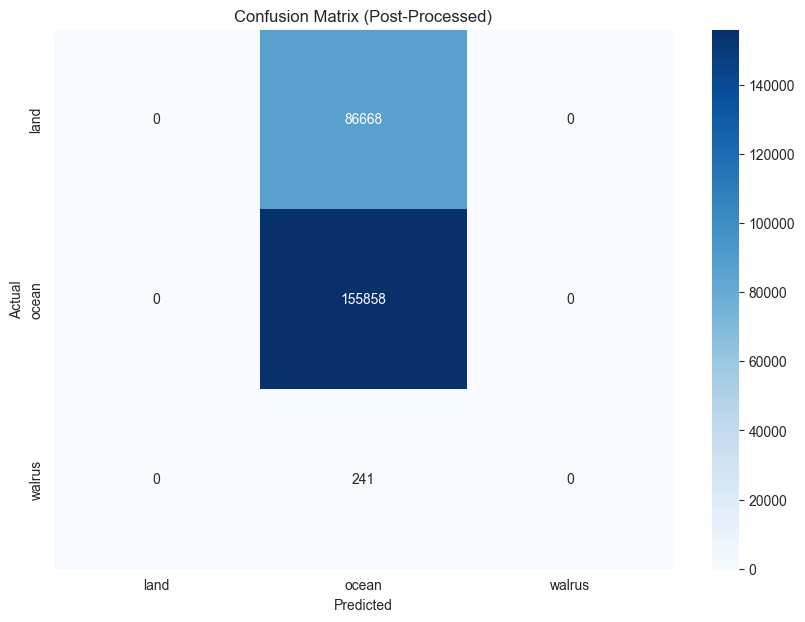

In [30]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        post_processed_predictions = post_process_prediction(predictions.reshape((src.height, src.width)))
        return post_processed_predictions

# Calculate post-processed metrics
y_pred = binary_model.predict(X_test_scaled)
y_pred_post_processed = [post_process_prediction(y.reshape(-1, 1)).flatten() for y in y_pred]
y_pred_post_processed = np.concatenate(y_pred_post_processed)

print("Binary Model - Ocean vs. Not Ocean (Post-Processed)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_post_processed)}")
print(f"Precision: {precision_score(y_test, y_pred_post_processed, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred_post_processed, average='weighted')}")
print(f"F1 Score: {f1_score(y_test, y_pred_post_processed, average='weighted')}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred_post_processed)}")

print("\nClassification Report for Binary Model (Post-Processed):")
print(classification_report(y_test, y_pred_post_processed, target_names=combined_le.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_post_processed)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=combined_le.classes_, 
            yticklabels=combined_le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Post-Processed)')
plt.show()

In [ ]:
# Predict classes for images with attached shapefiles
predicted_images = {}
for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, binary_model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels([combined_le.classes_[i] for i in range(len(combined_le.classes_))])
    
    # Highlight the labels present in the current image
    present_labels = [combined_le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [20]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import geometry_mask
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, precision_recall_curve
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy import ndimage

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

In [21]:
# Combine classes
dataset['combined_labels'] = dataset['labels'].apply(lambda x: 'land' if x in ['rock', 'ice', 'freshwater'] else ('walrus' if x in ['walrus_pure', 'walrus_mixed'] else x))
combined_le = LabelEncoder()
dataset['combined_encoded_labels'] = combined_le.fit_transform(dataset['combined_labels'])

# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, label_col='combined_encoded_labels', test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df[label_col]):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df[label_col].values for cls in [combined_le.transform(['walrus'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset, label_col='combined_encoded_labels')
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, train_df['combined_encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, test_df['combined_encoded_labels'].values

In [22]:
# Train the binary classifier (ocean vs. not ocean)
binary_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

binary_model.fit(X_train, y_train)

# Save the binary model
binary_model_filename = "binary_ocean_not_ocean_model.joblib"
joblib.dump(binary_model, binary_model_filename)

['binary_ocean_not_ocean_model.joblib']

In [ ]:
# Post-processing functions
def connected_component_analysis(prediction, min_size=50):
    labeled_array, num_features = ndimage.label(prediction)
    sizes = ndimage.sum(prediction, labeled_array, range(num_features + 1))
    mask = sizes < min_size
    remove_pixel = mask[labeled_array]
    prediction[remove_pixel] = 0
    return prediction

def proximity_filter(prediction, ocean_mask, radius=50):
    structure = ndimage.generate_binary_structure(2, 2)
    dilated_ocean = ndimage.binary_dilation(ocean_mask, structure=structure, iterations=radius)
    walrus_mask = prediction == combined_le.transform(['walrus'])[0]
    walrus_mask[~dilated_ocean] = False
    prediction[walrus_mask] = combined_le.transform(['walrus'])[0]
    prediction[(prediction == combined_le.transform(['walrus'])[0]) & (~walrus_mask)] = combined_le.transform(['land'])[0]
    return prediction

def post_process_prediction(prediction):
    ocean_mask = prediction == combined_le.transform(['ocean'])[0]
    land_mask = prediction == combined_le.transform(['land'])[0]
    
    ocean_mask = connected_component_analysis(ocean_mask)
    land_mask = connected_component_analysis(land_mask)
    
    prediction[ocean_mask] = combined_le.transform(['ocean'])[0]
    prediction[land_mask] = combined_le.transform(['land'])[0]
    
    prediction = proximity_filter(prediction, ocean_mask)
    
    return prediction

# Updated predict_image function
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        predictions = predictions.reshape((src.height, src.width))
        
        # Apply post-processing
        predictions = post_process_prediction(predictions)
        
        return predictions

# Apply predictions and post-processing to the test set
y_pred_post_processed = []

for image_path in test_df['image_name'].unique():
    full_image_path = os.path.join(image_dir, image_path)
    post_processed_image = predict_image(full_image_path, binary_model)
    y_pred_post_processed.extend(post_processed_image.flatten())

y_pred_post_processed = np.array(y_pred_post_processed)
y_test_flattened = y_test

In [ ]:
# Print accuracy metrics
print("Binary Model - Ocean vs. Not Ocean (Post-Processed)")
print(f"Accuracy: {accuracy_score(y_test_flattened, y_pred_post_processed)}")
print(f"Precision: {precision_score(y_test_flattened, y_pred_post_processed, average='weighted')}")
print(f"Recall: {recall_score(y_test_flattened, y_pred_post_processed, average='weighted')}")
print(f"F1 Score: {f1_score(y_test_flattened, y_pred_post_processed, average='weighted')}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test_flattened, y_pred_post_processed)}")

print("\nClassification Report for Binary Model:")
print(classification_report(y_test_flattened, y_pred_post_processed, target_names=combined_le.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_test_flattened, y_pred_post_processed)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=combined_le.classes_, 
            yticklabels=combined_le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Updated color map
label_colors = {
    'ocean': 'cornflowerblue',
    'land': 'antiquewhite',
    'walrus': 'mediumorchid'
}
cmap = mcolors.ListedColormap([label_colors[label] for label in combined_le.classes_])

# Predict and plot images
for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
    predicted_image = predict_image(image_path, binary_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels([combined_le.classes_[i] for i in range(len(combined_le.classes_))])
    
    present_labels = [combined_le.classes_[i] for i in np.unique(predicted_image)]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterio.features import geometry_mask
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import joblib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report
from scipy import ndimage

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})


In [3]:
# Combine classes
dataset['combined_labels'] = dataset['labels'].apply(lambda x: 'land' if x in ['rock', 'ice', 'freshwater'] else ('walrus' if x in ['walrus_pure', 'walrus_mixed'] else x))
combined_le = LabelEncoder()
dataset['combined_encoded_labels'] = combined_le.fit_transform(dataset['combined_labels'])

# Feature engineering
def create_walrus_index(blue, green):
    return (blue - green) / (blue + green)

dataset['walrus_index'] = create_walrus_index(dataset['Blue'], dataset['Green'])

# Add spatial context features
def add_spatial_context(df):
    for band in ['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']:
        df[f'{band}_mean'] = df.groupby('image_name')[band].transform('mean')
        df[f'{band}_std'] = df.groupby('image_name')[band].transform('std')
    return df

dataset = add_spatial_context(dataset)

# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, label_col='combined_encoded_labels', test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df[label_col]):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df[label_col].values for cls in [combined_le.transform(['walrus'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

In [4]:
# Split the data
train_df, test_df = custom_train_test_split(dataset, label_col='combined_encoded_labels')
X_train = train_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name'])
y_train = train_df['combined_encoded_labels'].values
X_test = test_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name'])
y_test = test_df['combined_encoded_labels'].values

# Train the binary classifier (ocean vs. not ocean)
binary_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

binary_model.fit(X_train, y_train)

# Save the binary model
binary_model_filename = "binary_ocean_not_ocean_model.joblib"
joblib.dump(binary_model, binary_model_filename)

# Post-processing functions
def connected_component_analysis(prediction, min_size=20):
    labeled_array, num_features = ndimage.label(prediction)
    sizes = ndimage.sum(prediction, labeled_array, range(num_features + 1))
    mask = sizes < min_size
    remove_pixel = mask[labeled_array]
    prediction[remove_pixel] = 0
    return prediction

def proximity_filter(prediction, ocean_mask, radius=20):
    structure = ndimage.generate_binary_structure(2, 2)
    dilated_ocean = ndimage.binary_dilation(ocean_mask, structure=structure, iterations=radius)
    walrus_mask = prediction == combined_le.transform(['walrus'])[0]
    walrus_mask[~dilated_ocean] = False
    prediction[walrus_mask] = combined_le.transform(['walrus'])[0]
    prediction[(prediction == combined_le.transform(['walrus'])[0]) & (~walrus_mask)] = combined_le.transform(['land'])[0]
    return prediction

def post_process_prediction(prediction):
    ocean_mask = prediction == combined_le.transform(['ocean'])[0]
    land_mask = prediction == combined_le.transform(['land'])[0]
    
    ocean_mask = connected_component_analysis(ocean_mask)
    land_mask = connected_component_analysis(land_mask)
    
    prediction[ocean_mask] = combined_le.transform(['ocean'])[0]
    prediction[land_mask] = combined_le.transform(['land'])[0]
    
    prediction = proximity_filter(prediction, ocean_mask)
    
    return prediction

# Updated predict_image function
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        
        # Add engineered features
        walrus_index = create_walrus_index(image_reshaped[:, 1], image_reshaped[:, 3])
        image_reshaped = np.column_stack((image_reshaped, walrus_index))
        
        # Add spatial context
        for i in range(image_reshaped.shape[1]):
            image_reshaped = np.column_stack((image_reshaped, 
                                              np.full(image_reshaped.shape[0], image_reshaped[:, i].mean()),
                                              np.full(image_reshaped.shape[0], image_reshaped[:, i].std())))
        
        predictions = model.predict(image_reshaped)
        predictions = predictions.reshape((src.height, src.width))
        
        # Apply post-processing
        predictions = post_process_prediction(predictions)
        
        return predictions


In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Binary Model - Ocean vs. Not Ocean
Accuracy: 0.9977014997919816
Precision: 0.9976988259419849
Recall: 0.9977014997919816
F1 Score: 0.9976716618299009
Cohen's Kappa: 0.9950077009796963

Classification Report for Binary Model:
              precision    recall  f1-score   support

        land       1.00      1.00      1.00     86668
       ocean       1.00      1.00      1.00    155858
      walrus       0.98      0.68      0.80       241

    accuracy                           1.00    242767
   macro avg       0.99      0.89      0.93    242767
weighted avg       1.00      1.00      1.00    242767


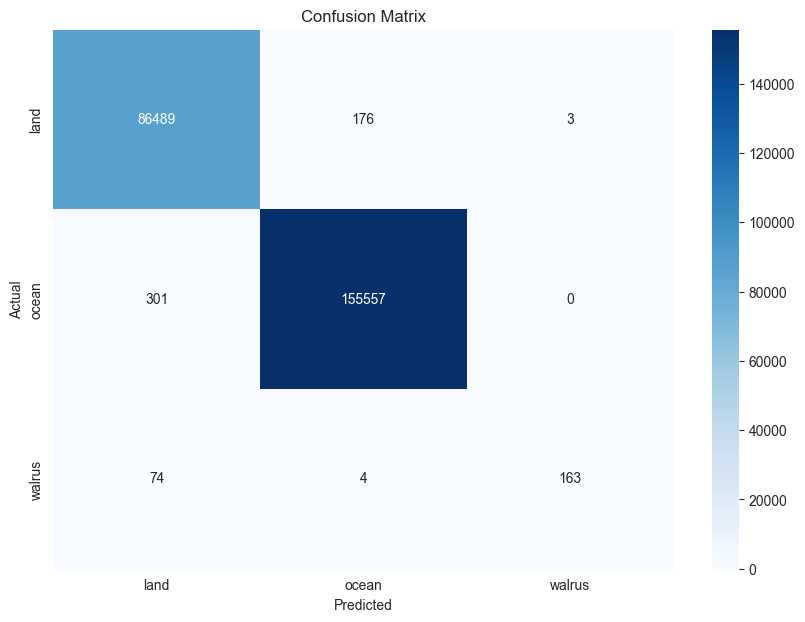

In [6]:
# Print accuracy metrics
y_pred = binary_model.predict(X_test)
print("Binary Model - Ocean vs. Not Ocean")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred)}")

print("\nClassification Report for Binary Model:")
print(classification_report(y_test, y_pred, target_names=combined_le.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=combined_le.classes_, 
            yticklabels=combined_le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [8]:
walrus_model = binary_model

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Labels present in buch_20230714_image.tif: ['ocean']


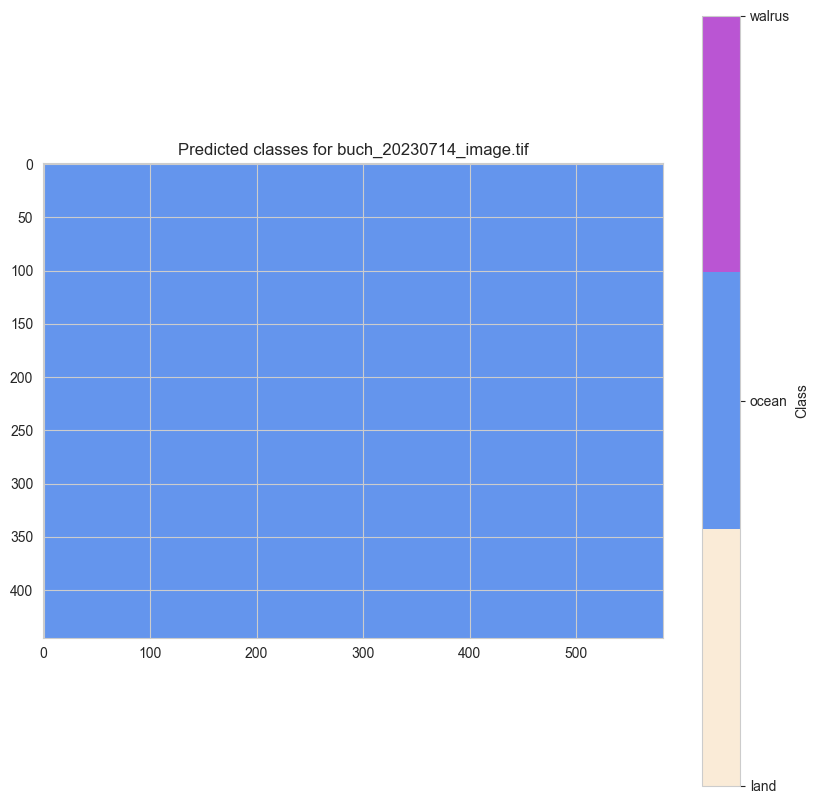

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from sklearn.preprocessing import StandardScaler

def create_walrus_index(blue, green):
    return (blue - green) / (blue + green)

def prepare_features(image):
    # Reshape the image
    image_reshaped = image.reshape((image.shape[0], -1)).T
    
    # Create walrus index
    walrus_index = create_walrus_index(image_reshaped[:, 1], image_reshaped[:, 3])
    
    # Combine original bands and walrus index
    features = np.column_stack((image_reshaped, walrus_index))
    
    # Add spatial context (mean and std for each band)
    for i in range(image_reshaped.shape[1]):
        features = np.column_stack((features, 
                                    np.full(features.shape[0], features[:, i].mean()),
                                    np.full(features.shape[0], features[:, i].std())))
    
    # Ensure we have exactly 25 features
    if features.shape[1] > 25:
        features = features[:, :25]
    elif features.shape[1] < 25:
        # Add dummy features if we have less than 25
        features = np.pad(features, ((0, 0), (0, 25 - features.shape[1])), mode='constant')
    
    # Standardize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    return features

def predict_image_combined(image_path, binary_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_features = prepare_features(image)

        # Predict using the binary model
        predictions = binary_model.predict(image_features)

        # Reshape predictions back to image shape
        predictions = predictions.reshape((src.height, src.width))

        return predictions

# Define a color map for the labels
label_colors = {
    'ocean': 'cornflowerblue',
    'land': 'antiquewhite',
    'walrus': 'mediumorchid'
}

# Create a fixed color map based on combined labels
cmap = plt.cm.colors.ListedColormap([label_colors[label] for label in combined_le.classes_])

# Predict and plot images
for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
    predicted_image = predict_image_combined(image_path, binary_model, walrus_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_) - 1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels(combined_le.classes_)

    # Highlight the labels present in the current image
    unique_labels = np.unique(predicted_image)
    present_labels = [combined_le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import rasterio
from scipy import ndimage

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


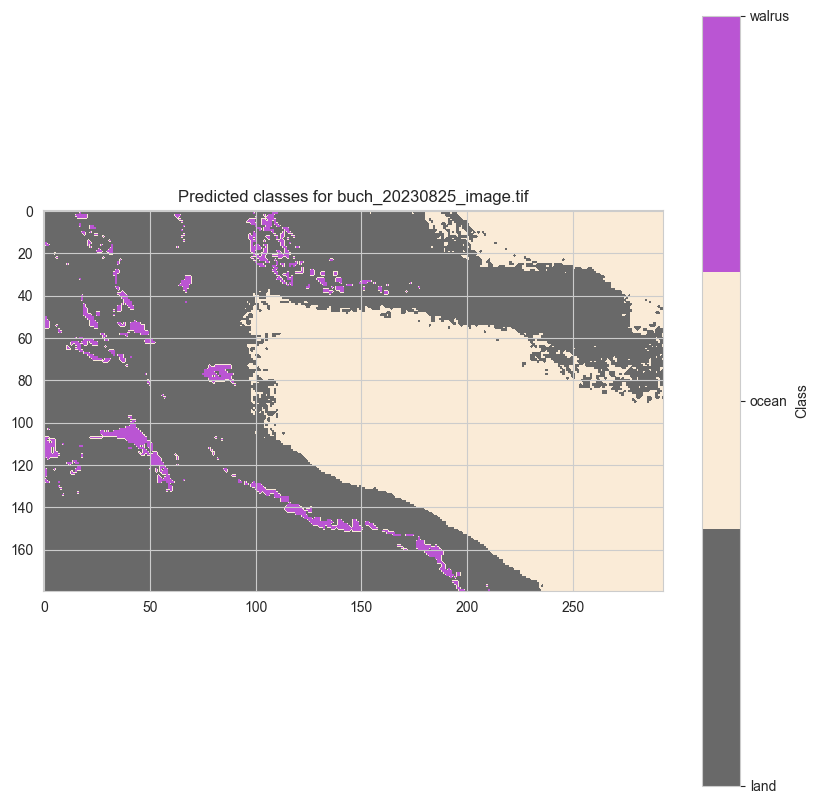

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


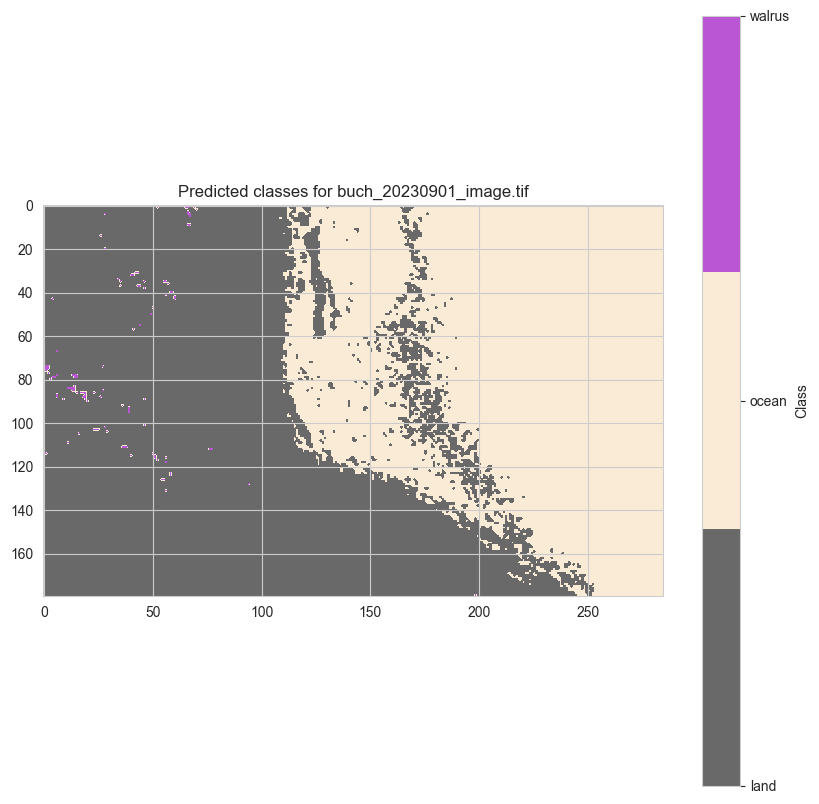

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


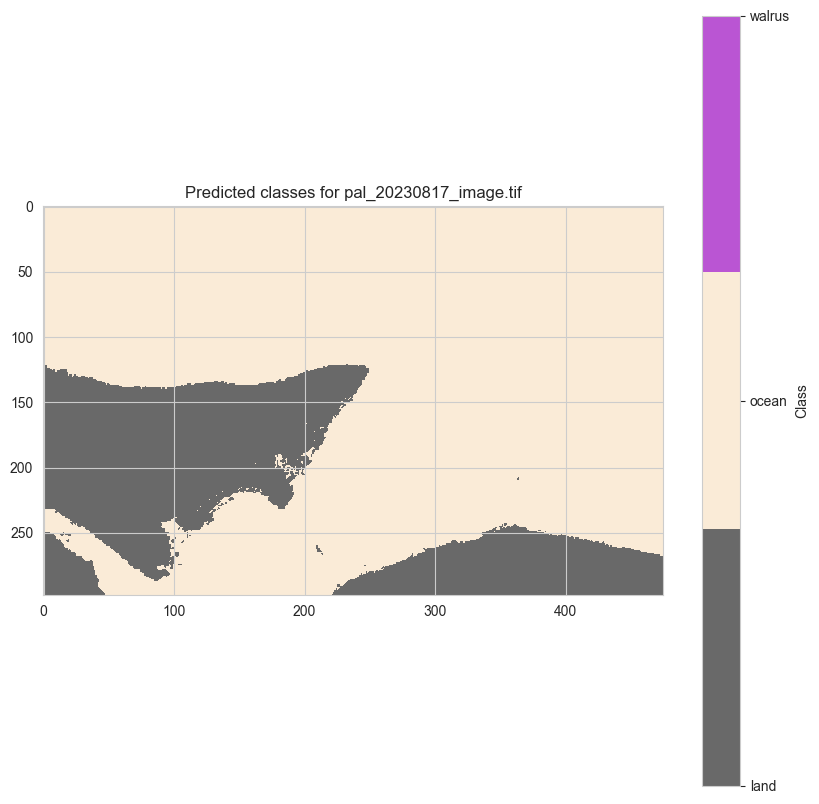

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


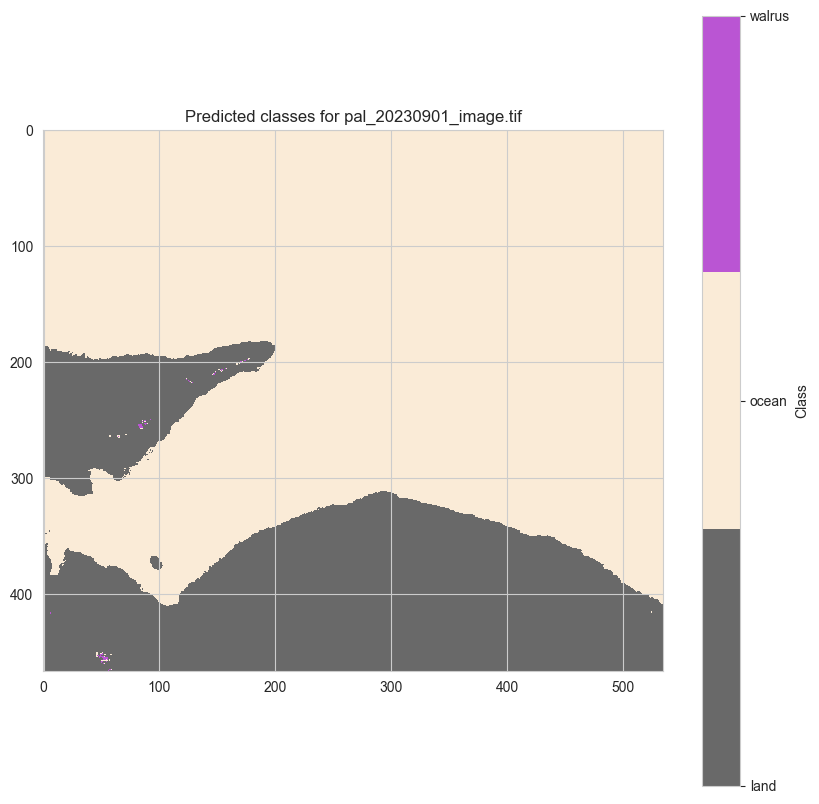

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


KeyboardInterrupt: 

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import rasterio
from scipy import ndimage

# Define the same feature engineering functions used during training
def create_walrus_index(blue, green):
    return (blue - green) / (blue + green)

def add_spatial_context(df):
    for band in ['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']:
        df[f'{band}_mean'] = df.groupby('image_name')[band].transform('mean')
        df[f'{band}_std'] = df.groupby('image_name')[band].transform('std')
    return df

# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        image_name = [os.path.basename(image_path)] * image_reshaped.shape[0]

        # Create a DataFrame for the image
        df = pd.DataFrame(image_reshaped, columns=['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR'])
        df['image_name'] = image_name
        
        # Add engineered features
        df['walrus_index'] = create_walrus_index(df['Blue'], df['Green'])
        
        # Add spatial context features
        df = add_spatial_context(df)
        
        # Drop the 'image_name' column before prediction
        image_reshaped = df.drop(columns=['image_name']).values
        
        # Predict
        predictions = model.predict(image_reshaped)
        predictions = predictions.reshape((src.height, src.width))
        
        return predictions

# Load the saved binary model
binary_model = joblib.load("binary_ocean_not_ocean_model.joblib")

# Define a color map for the labels
label_colors = {
    'ocean': 'cornflowerblue',
    'land': 'antiquewhite',
    'walrus': 'mediumorchid'
}
cmap = mcolors.ListedColormap([label_colors[label] for label in combined_le.classes_])

# Predict classes for unlabeled images
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, binary_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels([combined_le.classes_[i] for i in range(len(combined_le.classes_))])
    
    plt.show()


In [1]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import geometry_mask
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, precision_recall_curve
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

In [3]:
# Combine classes
dataset['combined_labels'] = dataset['labels'].apply(lambda x: 'land' if x in ['rock', 'ice', 'freshwater'] else ('walrus' if x in ['walrus_pure', 'walrus_mixed'] else x))
combined_le = LabelEncoder()
dataset['combined_encoded_labels'] = combined_le.fit_transform(dataset['combined_labels'])

# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, label_col='combined_encoded_labels', test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df[label_col]):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df[label_col].values for cls in [combined_le.transform(['walrus'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset, label_col='combined_encoded_labels')
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, train_df['combined_encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, test_df['combined_encoded_labels'].values


In [4]:
# Train the binary classifier (ocean vs. not ocean)
binary_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

binary_model.fit(X_train, y_train)

# Save the binary model
binary_model_filename = "binary_ocean_not_ocean_model.joblib"
joblib.dump(binary_model, binary_model_filename)

['binary_ocean_not_ocean_model.joblib']

In [5]:
# Filter land and walrus pixels
not_ocean_mask = train_df['combined_labels'] == 'land'
X_train_not_ocean = X_train[not_ocean_mask]
y_train_not_ocean = train_df.loc[not_ocean_mask, 'encoded_labels'].values

# Train the classifier for walrus vs. land
walrus_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
], voting='soft')

walrus_model.fit(X_train_not_ocean, y_train_not_ocean)
joblib.dump(walrus_model, "walrus_vs_land_model.joblib")


# Save the walrus model
walrus_model_filename = "walrus_vs_land_model.joblib"
joblib.dump(walrus_model, walrus_model_filename)

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [03:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['walrus_vs_land_model.joblib']

Binary Model - Ocean vs. Not Ocean
Accuracy: 0.9972689863119781
Precision: 0.997265578237944
Recall: 0.9972689863119781
F1 Score: 0.997185828120288
Cohen's Kappa: 0.9940676362336646

Classification Report for Binary Model:
              precision    recall  f1-score   support

        land       0.99      1.00      1.00     86668
       ocean       1.00      1.00      1.00    155858
      walrus       0.98      0.49      0.66       241

    accuracy                           1.00    242767
   macro avg       0.99      0.83      0.88    242767
weighted avg       1.00      1.00      1.00    242767


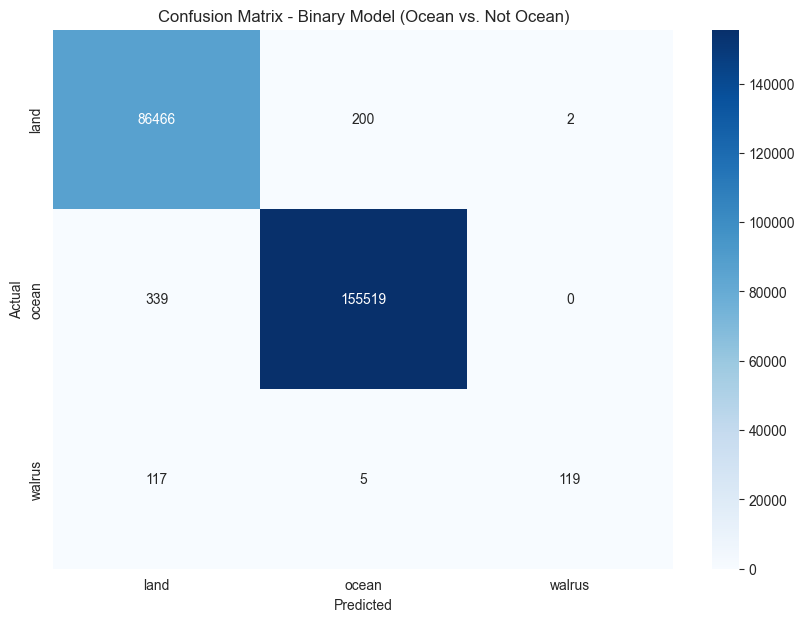

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Walrus Model - Walrus vs. Land
Accuracy: 0.0894959095145497
Precision: 0.9941593803905401
Recall: 0.0894959095145497
F1 Score: 0.16420941009435785
Cohen's Kappa: -2.988720118990429e-05

Classification Report for Walrus Model:


ValueError: Number of classes, 4, does not match size of target_names, 2. Try specifying the labels parameter

In [49]:
# Evaluate the binary model
y_pred_binary = binary_model.predict(X_test)

# Calculate evaluation metrics for binary model
accuracy_binary = accuracy_score(y_test, y_pred_binary)
precision_binary = precision_score(y_test, y_pred_binary, average='weighted')
recall_binary = recall_score(y_test, y_pred_binary, average='weighted')
f1_binary = f1_score(y_test, y_pred_binary, average='weighted')
kappa_binary = cohen_kappa_score(y_test, y_pred_binary)
conf_matrix_binary = confusion_matrix(y_test, y_pred_binary)

# Print evaluation metrics for binary model
print(f"Binary Model - Ocean vs. Not Ocean")
print(f"Accuracy: {accuracy_binary}")
print(f"Precision: {precision_binary}")
print(f"Recall: {recall_binary}")
print(f"F1 Score: {f1_binary}")
print(f"Cohen's Kappa: {kappa_binary}")
print("\nClassification Report for Binary Model:")
print(classification_report(y_test, y_pred_binary, target_names=combined_le.classes_))

# Plot the confusion matrix for binary model
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_binary, annot=True, fmt='d', cmap='Blues', xticklabels=combined_le.classes_, yticklabels=combined_le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Binary Model (Ocean vs. Not Ocean)')
plt.show()

# Evaluate the walrus model on not_ocean pixels
not_ocean_test_mask = y_test != combined_le.transform(['ocean'])[0]
X_test_not_ocean = X_test[not_ocean_test_mask]
y_test_not_ocean = y_test[not_ocean_test_mask]

y_pred_walrus = walrus_model.predict(X_test_not_ocean)

# Calculate evaluation metrics for walrus model
accuracy_walrus = accuracy_score(y_test_not_ocean, y_pred_walrus)
precision_walrus = precision_score(y_test_not_ocean, y_pred_walrus, average='weighted')
recall_walrus = recall_score(y_test_not_ocean, y_pred_walrus, average='weighted')
f1_walrus = f1_score(y_test_not_ocean, y_pred_walrus, average='weighted')
kappa_walrus = cohen_kappa_score(y_test_not_ocean, y_pred_walrus)
conf_matrix_walrus = confusion_matrix(y_test_not_ocean, y_pred_walrus)

# Print evaluation metrics for walrus model
print(f"Walrus Model - Walrus vs. Land")
print(f"Accuracy: {accuracy_walrus}")
print(f"Precision: {precision_walrus}")
print(f"Recall: {recall_walrus}")
print(f"F1 Score: {f1_walrus}")
print(f"Cohen's Kappa: {kappa_walrus}")
print("\nClassification Report for Walrus Model:")
print(classification_report(y_test_not_ocean, y_pred_walrus, target_names=[le.classes_[i] for i in np.unique(y_test_not_ocean)]))

# Plot the confusion matrix for walrus model
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_walrus, annot=True, fmt='d', cmap='Blues', xticklabels=[le.classes_[i] for i in np.unique(y_test_not_ocean)], yticklabels=[le.classes_[i] for i in np.unique(y_test_not_ocean)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Walrus Model (Walrus vs. Land)')
plt.show()

Labels present in buch_20230714_image.tif: ['land', 'ocean', 'walrus']


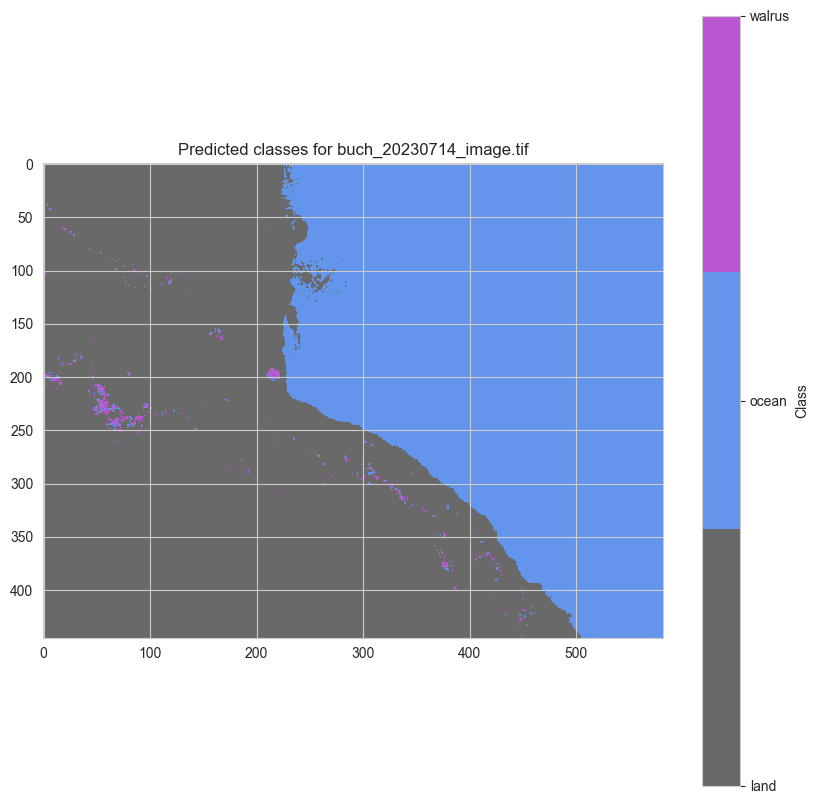

Labels present in buch_20230720_image.tif: ['land', 'ocean', 'walrus']


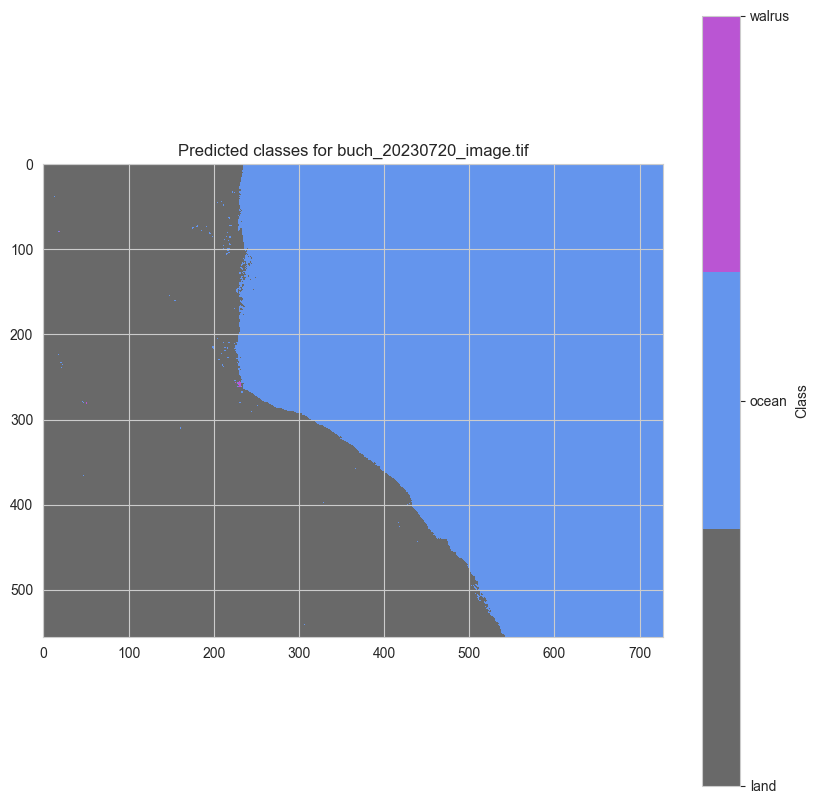

Labels present in buch_20230731_image.tif: ['land', 'ocean', 'walrus']


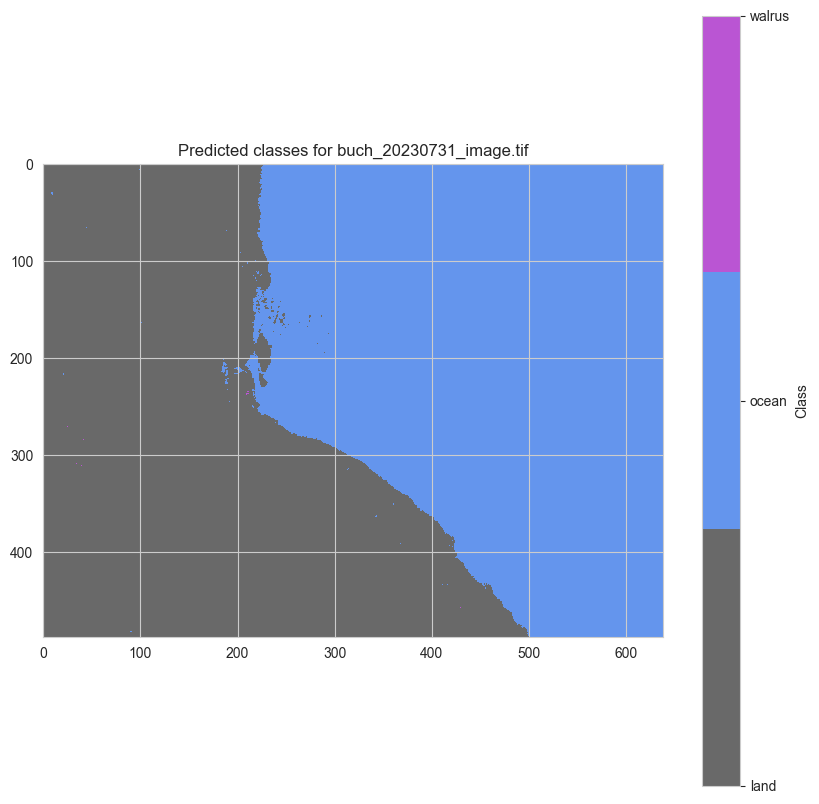

Labels present in buch_20230923_image.tif: ['land', 'ocean']


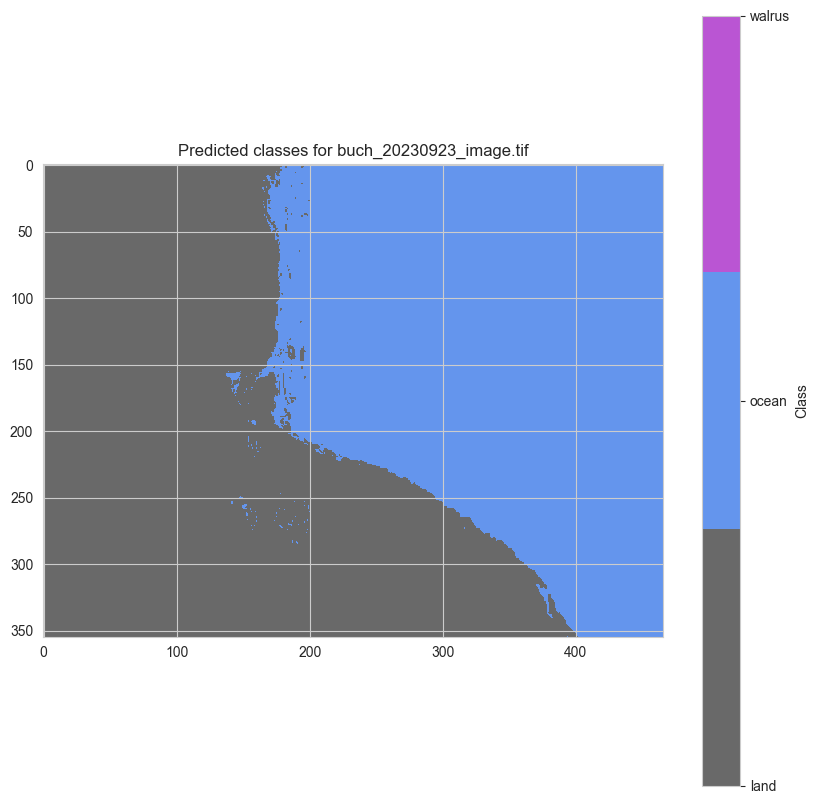

Labels present in moff_20230717_image.tif: ['land', 'ocean', 'walrus']


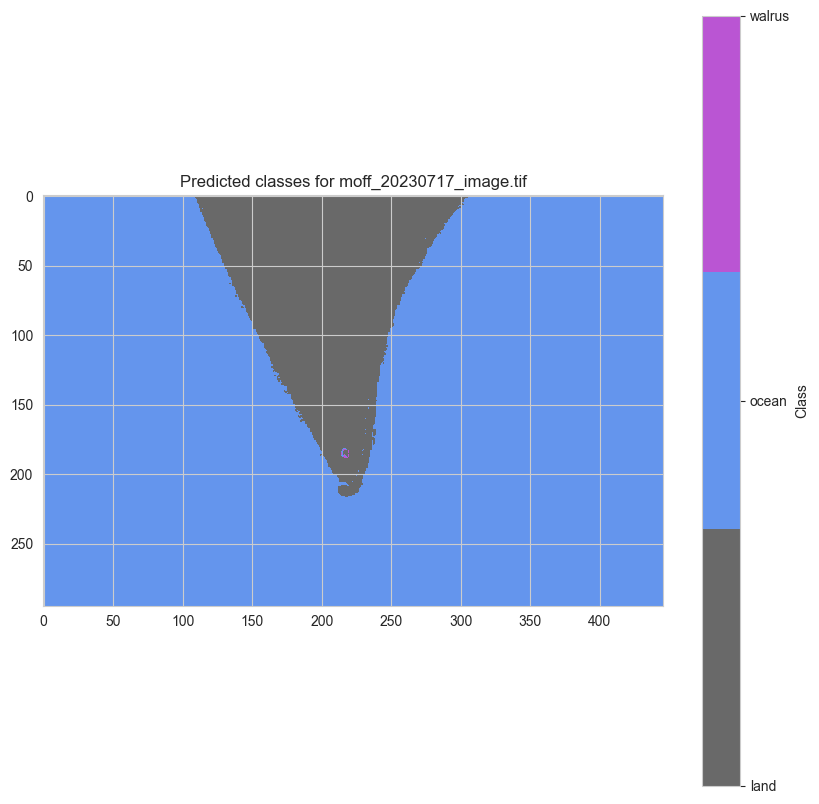

Labels present in pal_20230714_image.tif: ['land', 'ocean', 'walrus']


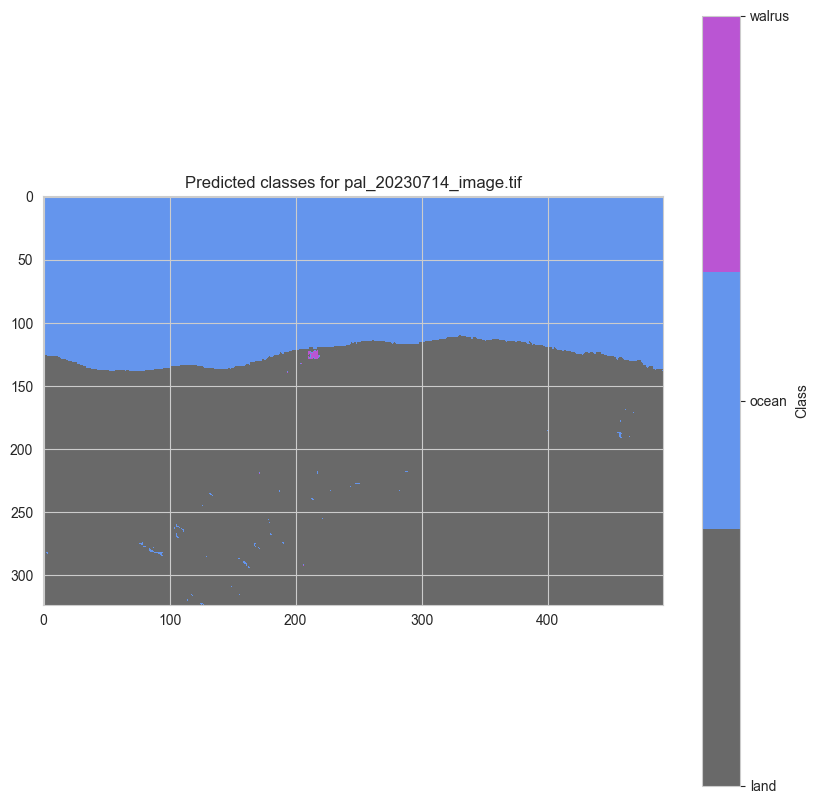

Labels present in pal_20230720_image.tif: ['land', 'ocean', 'walrus']


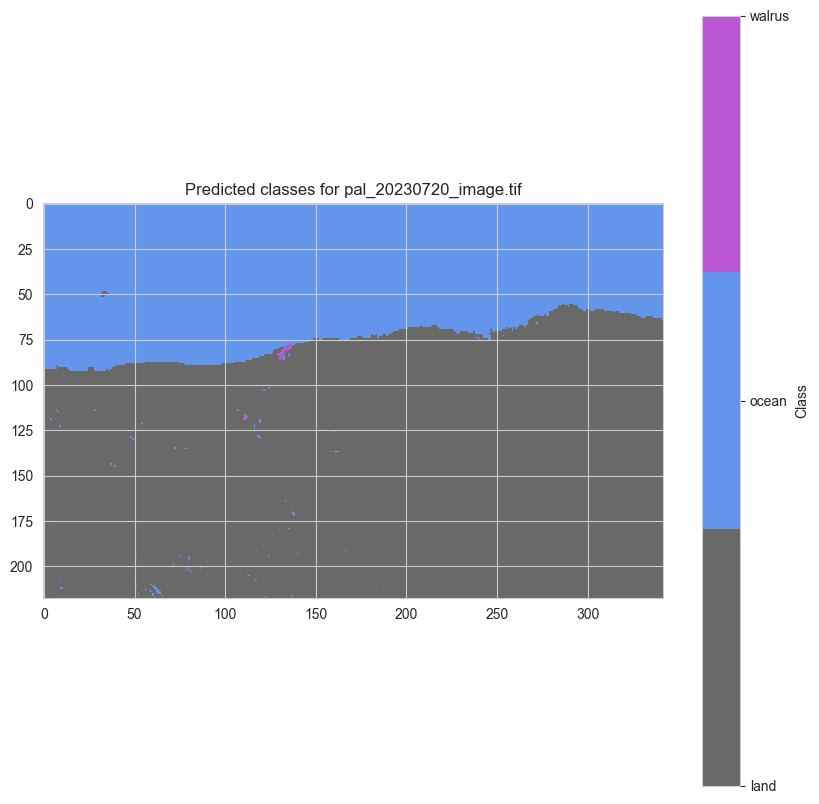

Labels present in pal_20230726_image.tif: ['land', 'ocean', 'walrus']


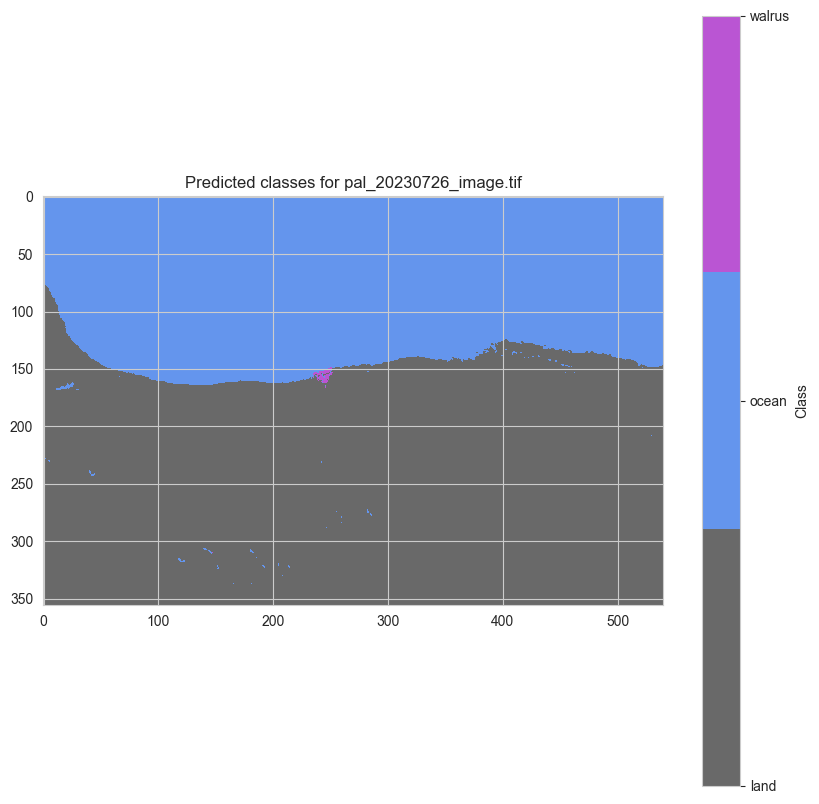

Labels present in sars_20230714_image.tif: ['land', 'ocean', 'walrus']


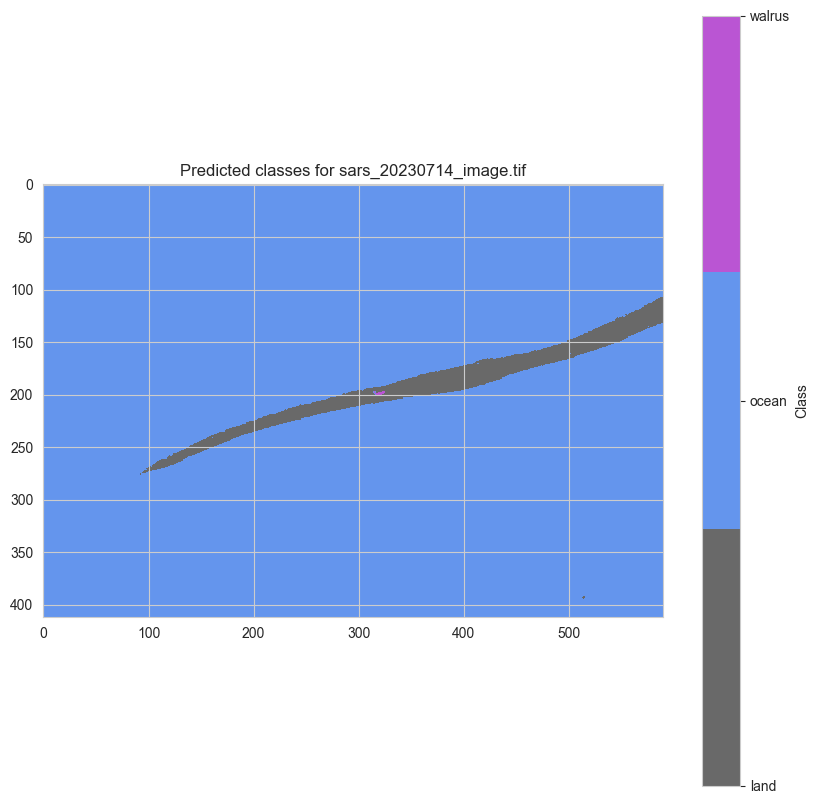

Labels present in sars_20230803_image.tif: ['land', 'ocean', 'walrus']


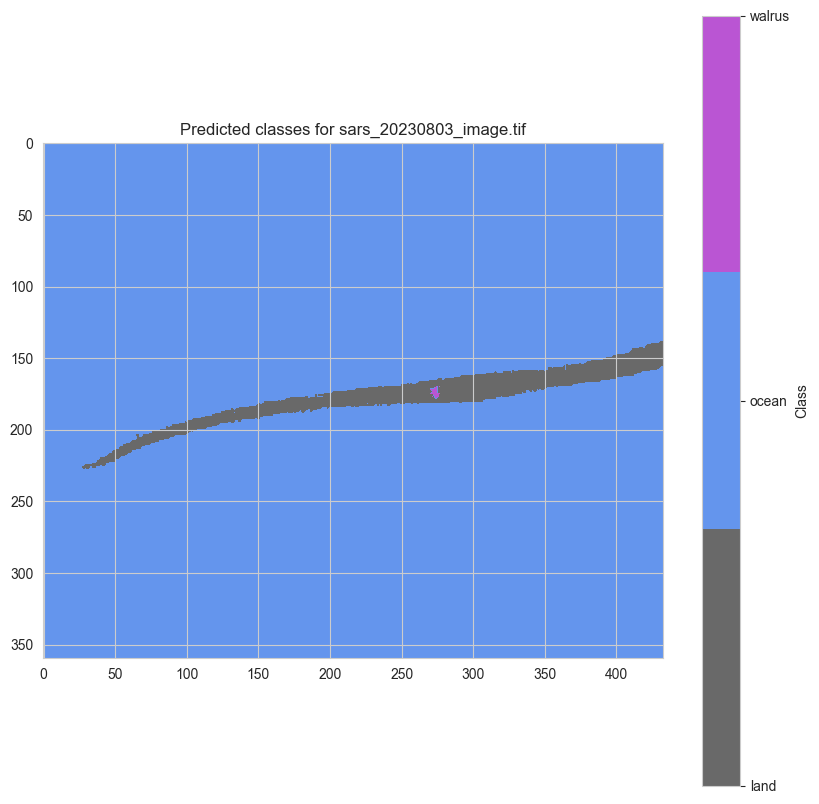

Labels present in tor_20230801_image.tif: ['land', 'ocean', 'walrus']


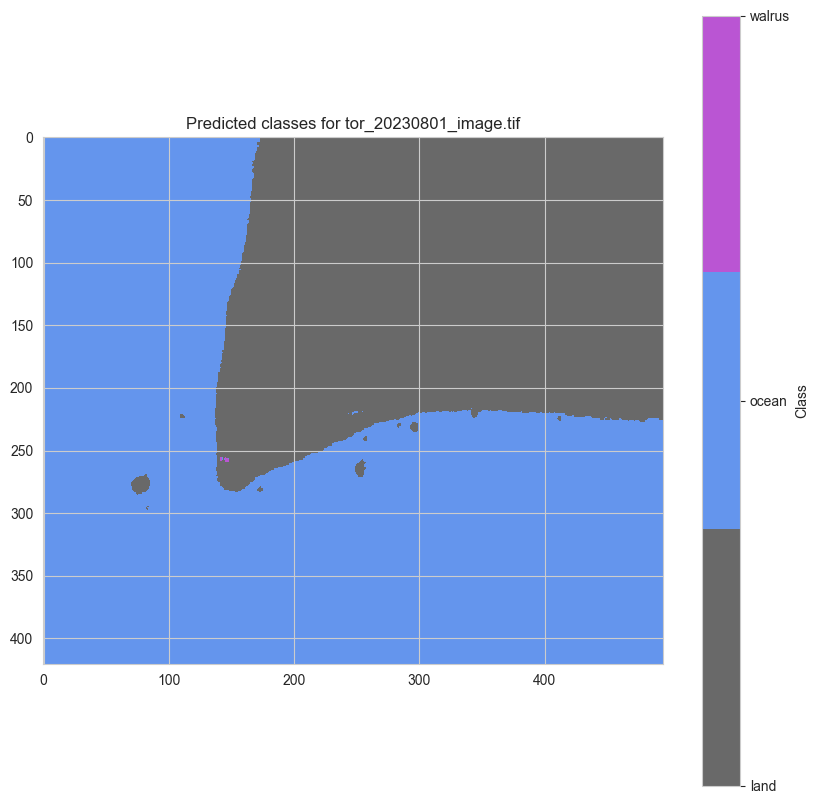

Labels present in tor_20230824_image.tif: ['land', 'ocean', 'walrus']


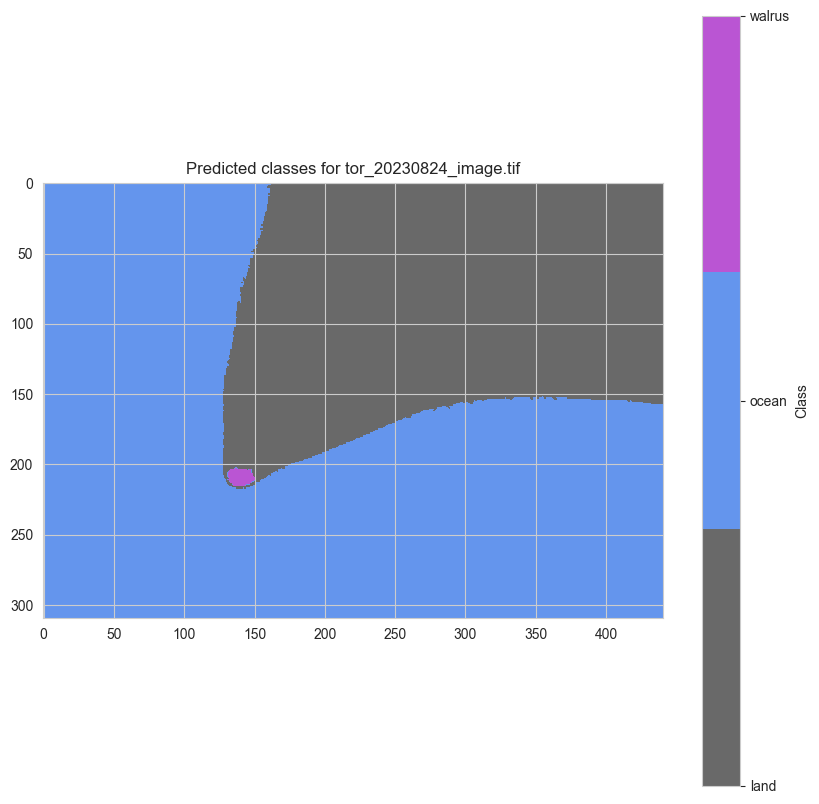

Labels present in tor_20230901_image.tif: ['land', 'ocean', 'walrus']


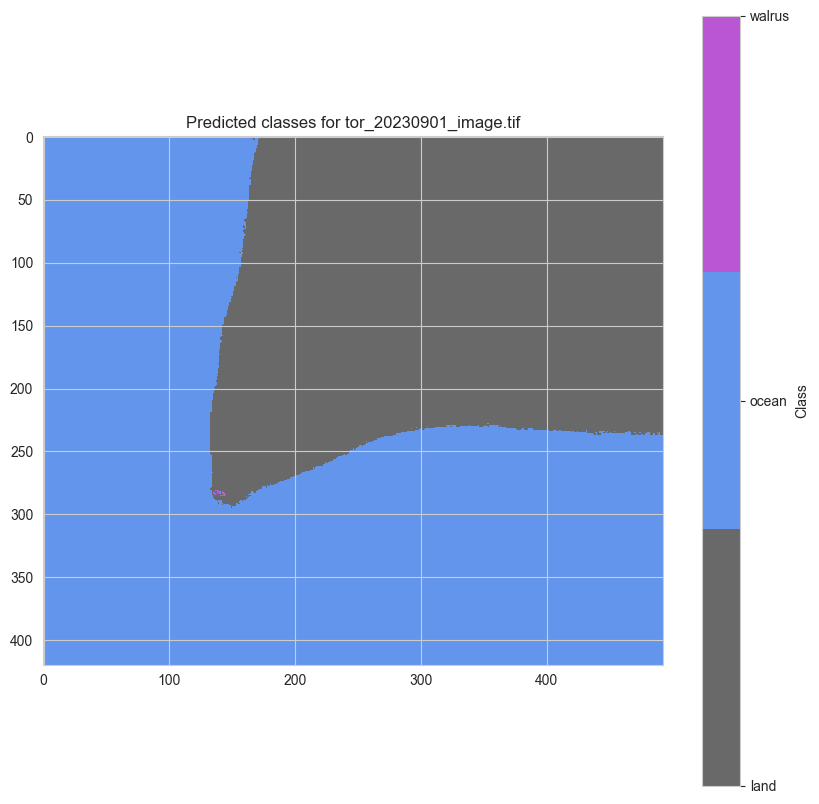

Labels present in tor_20230902_image.tif: ['land', 'ocean', 'walrus']


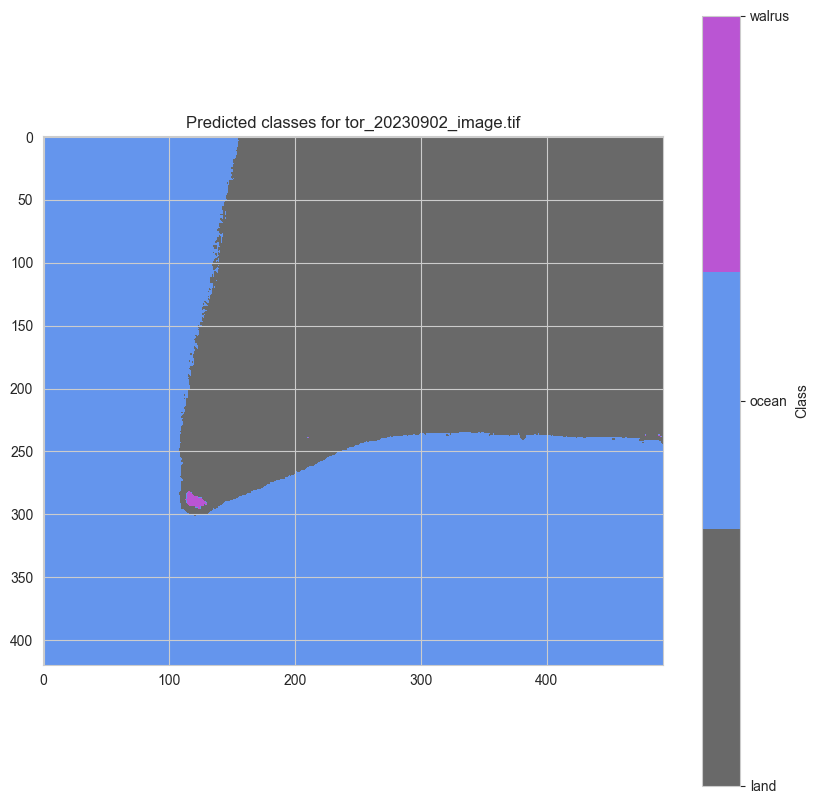

In [50]:
# Define a color map for the labels
label_colors = {
    'ocean': 'cornflowerblue',
    'land': 'antiquewhite',
    'walrus': 'mediumorchid'
}

# Create a fixed color map based on combined labels
cmap = mcolors.ListedColormap([label_colors[label] for label in combined_le.classes_])

# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

# Predict classes for images with attached shapefiles
predicted_images = {}
for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, binary_model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels([combined_le.classes_[i] for i in range(len(combined_le.classes_))])
    
    # Highlight the labels present in the current image
    present_labels = [combined_le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


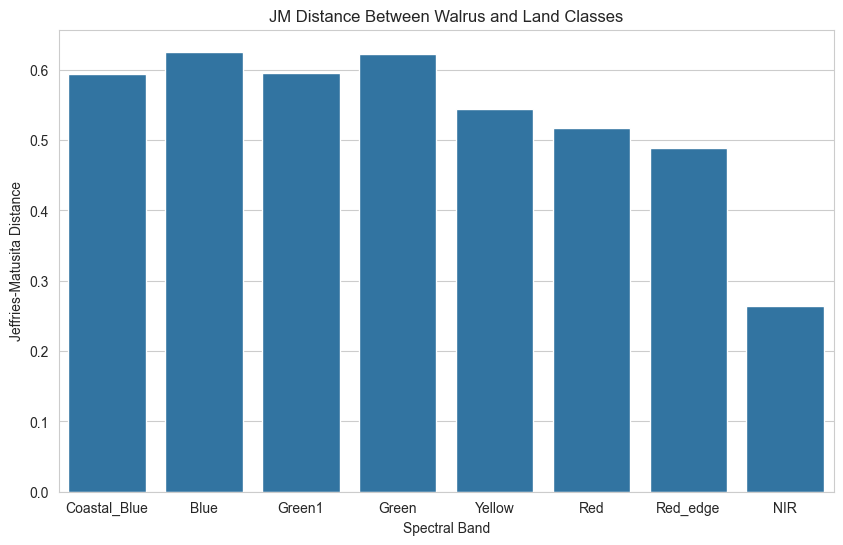

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate Jeffries-Matusita distance
def jm_distance(mean1, mean2, var1, var2):
    diff_mean = mean1 - mean2
    avg_var = (var1 + var2) / 2
    jm = 0.125 * (diff_mean ** 2) / avg_var + 0.5 * np.log(avg_var / np.sqrt(var1 * var2))
    return jm

# Extract features for walrus and land classes
walrus_features = features[np.isin(encoded_labels, le.transform(['walrus_pure', 'walrus_mixed']))]
land_features = features[np.isin(encoded_labels, le.transform(['rock', 'ice', 'freshwater']))]

# Calculate means and variances
walrus_mean = np.mean(walrus_features, axis=0)
land_mean = np.mean(land_features, axis=0)
walrus_var = np.var(walrus_features, axis=0)
land_var = np.var(land_features, axis=0)

# Calculate JM distance for each spectral band
jm_distances = []
for i in range(walrus_features.shape[1]):
    jm_distances.append(jm_distance(walrus_mean[i], land_mean[i], walrus_var[i], land_var[i]))

# Plot the JM distance
bands = ['Coastal_Blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']
plt.figure(figsize=(10, 6))
sns.barplot(x=bands, y=jm_distances)
plt.xlabel('Spectral Band')
plt.ylabel('Jeffries-Matusita Distance')
plt.title('JM Distance Between Walrus and Land Classes')
plt.show()


In [ ]:
import concurrent.futures
import matplotlib.colors as mcolors
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import geometry_mask
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, precision_recall_curve
import joblib
import matplotlib.py

In [31]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(image_paths, shapefile_paths, new_walrus_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in new_walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths, new_walrus_paths)


def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs, max_images=5):
    features = []
    labels = []
    image_name = []
    count = 0

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        if count >= max_images:
            break
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)
        count += 1

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels and combine classes
label_mapping = {
    'ocean': 'ocean',
    'ice': 'not_ocean',
    'freshwater': 'not_ocean',
    'rock': 'not_ocean',
    'walrus_mixed': 'walrus',
    'walrus_pure': 'walrus'
}
labels_combined = [label_mapping[label] for label in labels]
le = LabelEncoder()
encoded_labels = le.fit_transform(labels_combined)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
}) 
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

X_train = X_train
X_test = X_test


ValueError: y contains previously unseen labels: 'walrus_pu'

In [ ]:
# Define base models
base_models = [
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Define meta-model
meta_model = LogisticRegression()

# Create the stacking ensemble
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, passthrough=True)

# Train the stacking ensemble
stacking_model.fit(X_train, y_train)

# Save the stacking ensemble model
model_filename = "stacking_ensemble_model.joblib"
joblib.dump(stacking_model, model_filename)
print(f"Model saved as {model_filename}")


In [ ]:
# Evaluate the stacking ensemble model
y_pred = stacking_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the Precision-Recall Curve
y_proba = stacking_model.predict_proba(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])  # assuming binary classification for precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [ ]:
# Define custom colormap for the classes
class_colors = {
    'ocean': '#1f77b4',
    'not_ocean': '#aec7e8',
    'walrus': '#d62728'
}
cmap = plt.cm.colors.ListedColormap([class_colors[cls] for cls in le.classes_])

def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = image.reshape((image.shape[0], -1)).T  # Reshape for prediction
    predictions = model.predict(features)
    predicted_image = predictions.reshape((image.shape[1], image.shape[2]))
    return predicted_image

# Example visualization of training images
predicted_images = {}
for image_path in image_paths[:5]:  # Limiting to first 5 images for example
    predicted_images[image_path] = predict_image(image_path, stacking_model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels([le.classes_[i] for i in range(len(le.classes_))])
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [26]:
import concurrent.futures
import matplotlib.colors as mcolors

In [24]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import geometry_mask
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, precision_recall_curve
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(image_paths, shapefile_paths, new_walrus_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in new_walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths, new_walrus_paths)


def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs, max_images=5):
    features = []
    labels = []
    image_name = []
    count = 0

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        if count >= max_images:
            break
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)
        count += 1

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
}) 
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

X_train = X_train
X_test = X_test


In [27]:
# Ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Save the ensemble model
model_filename = "ensemble_model1.joblib"
joblib.dump(ensemble_model, model_filename)
print(f"Model saved as {model_filename}")


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:56:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model saved as ensemble_model1.joblib


Accuracy: 0.9846864463381857
Precision: 0.9843897233091087
Recall: 0.9846864463381857
F1 Score: 0.9844175634790705
Cohen's Kappa: 0.9711581213761428

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.91      0.88      0.89      6953
         ice       0.98      0.99      0.98     41582
       ocean       1.00      1.00      1.00     73803
        rock       0.93      0.82      0.87      1858
walrus_mixed       0.68      0.29      0.40        59
 walrus_pure       0.18      0.14      0.16        14

    accuracy                           0.98    124269
   macro avg       0.78      0.69      0.72    124269
weighted avg       0.98      0.98      0.98    124269


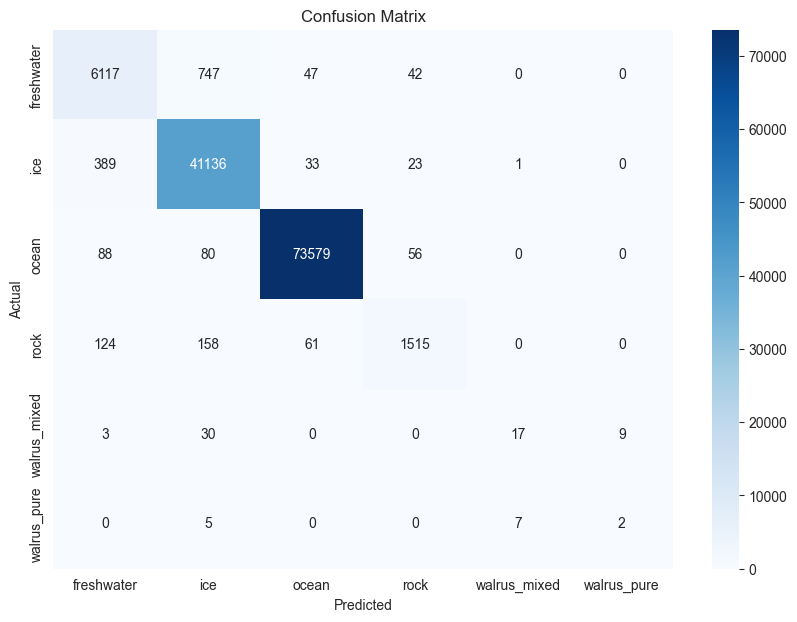

ValueError: multiclass format is not supported

In [28]:
# Evaluate the ensemble model
y_pred = ensemble_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the Precision-Recall Curve
y_proba = ensemble_model.predict_proba(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])  # assuming binary classification for precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [29]:
model = ensemble_model

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


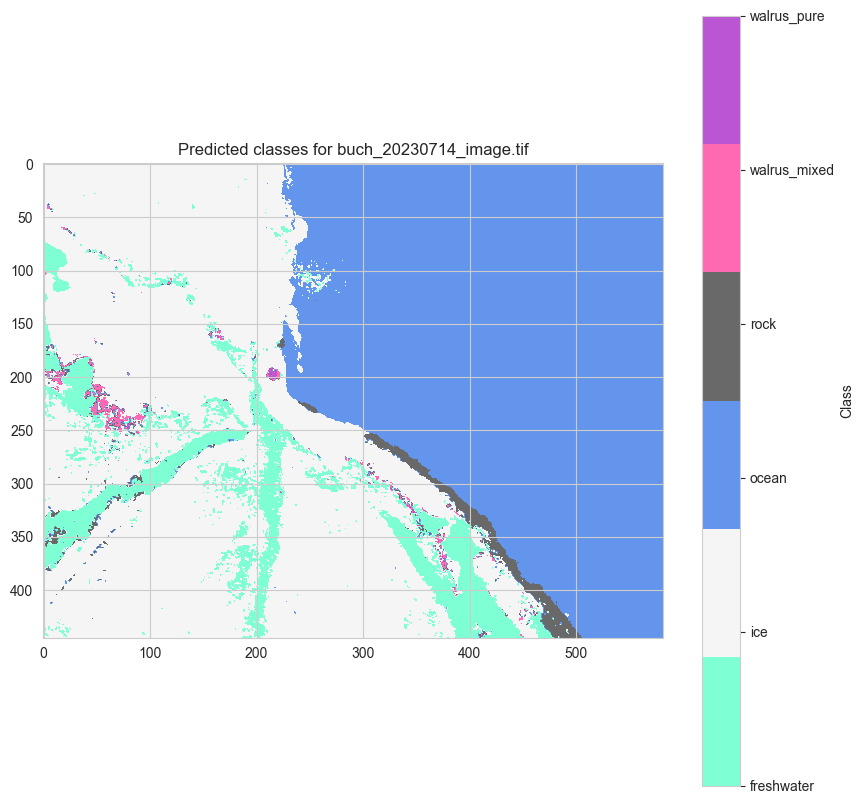

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


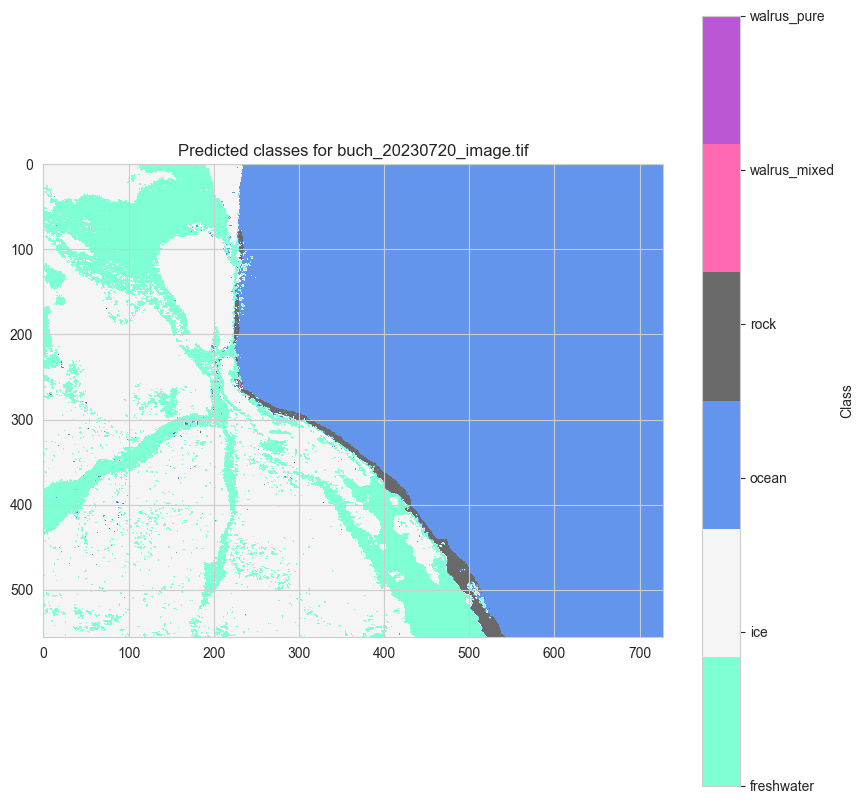

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


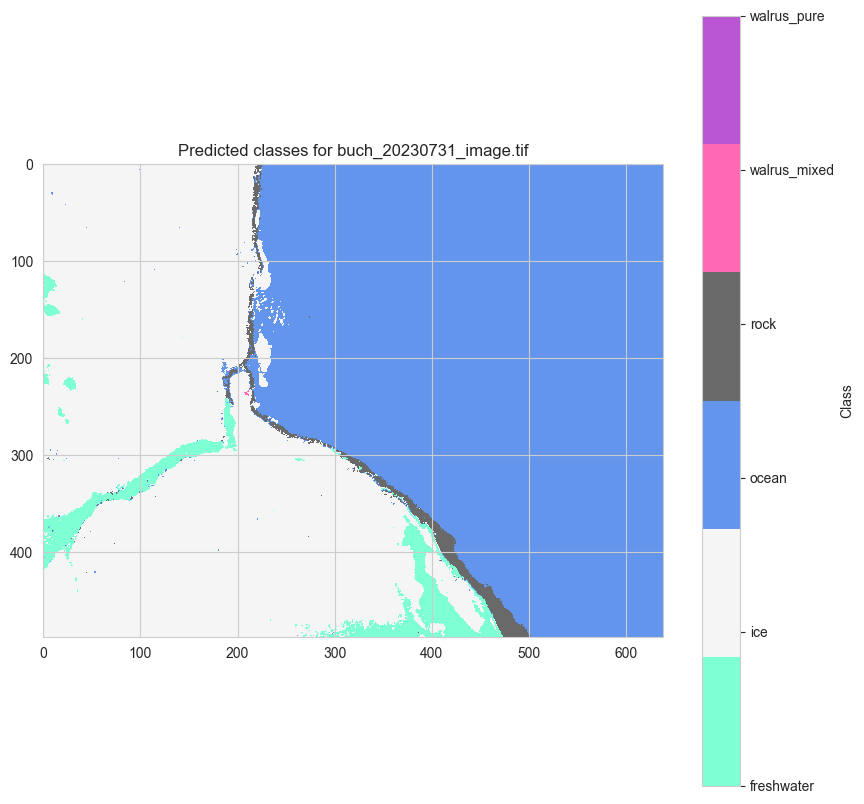

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


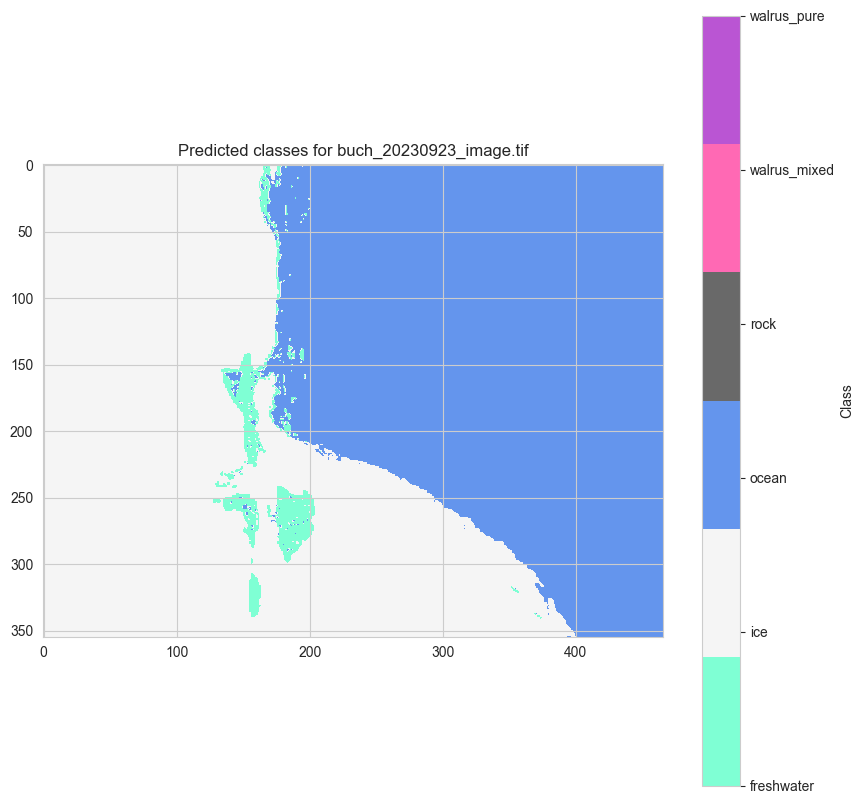

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


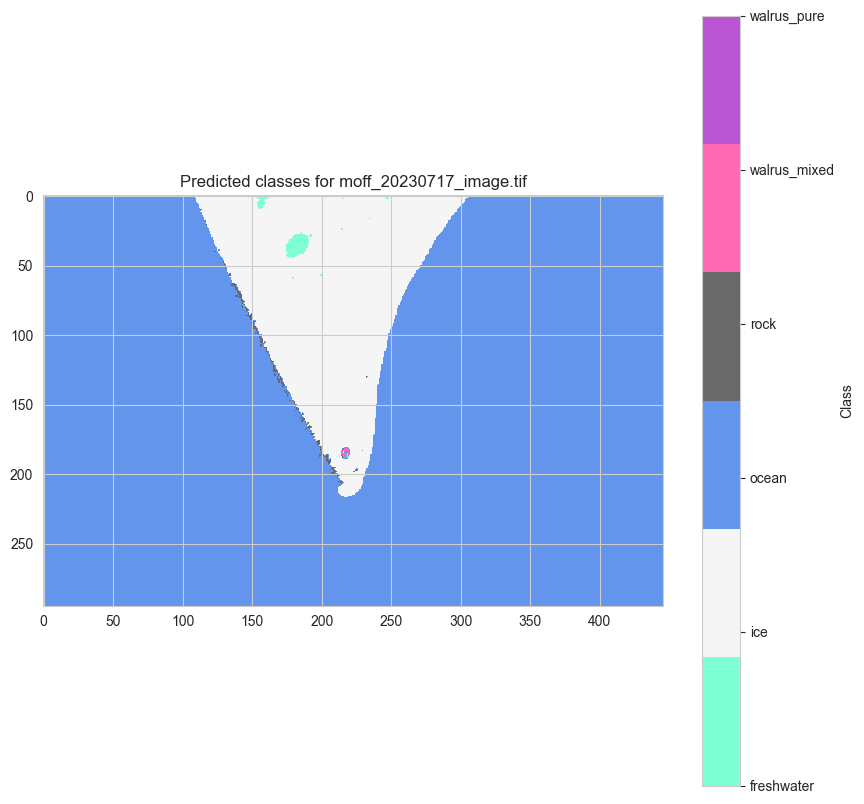

Labels present in pal_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


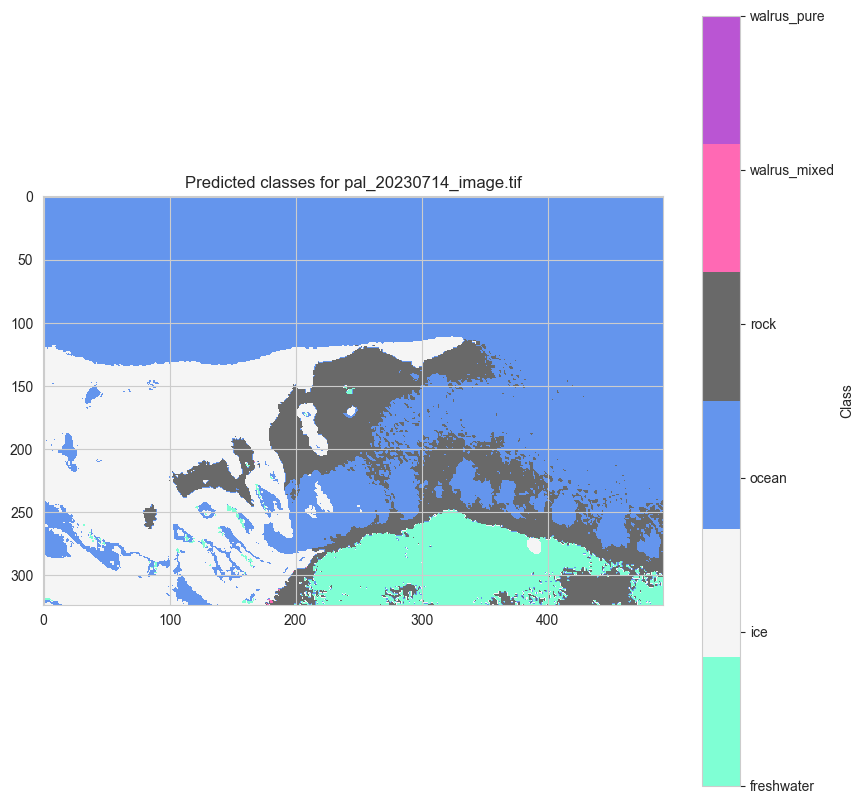

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


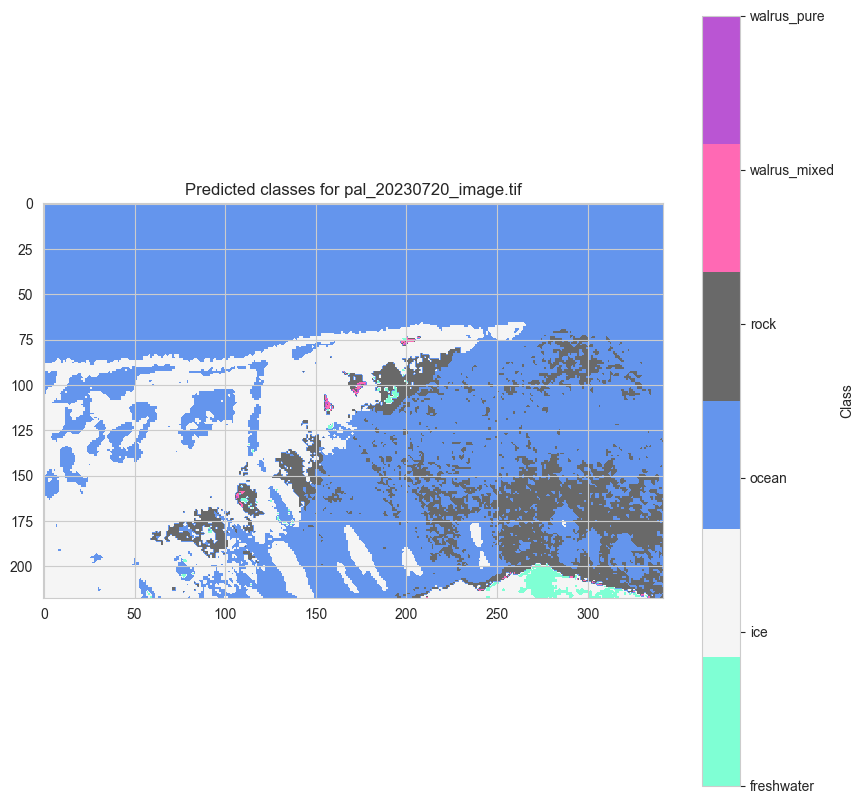

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


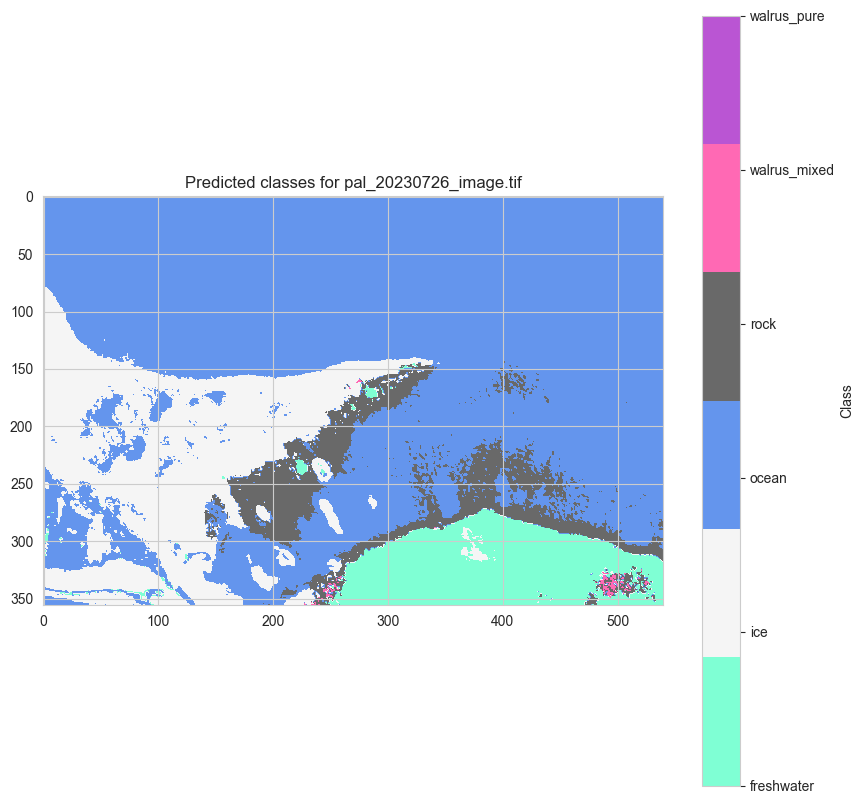

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


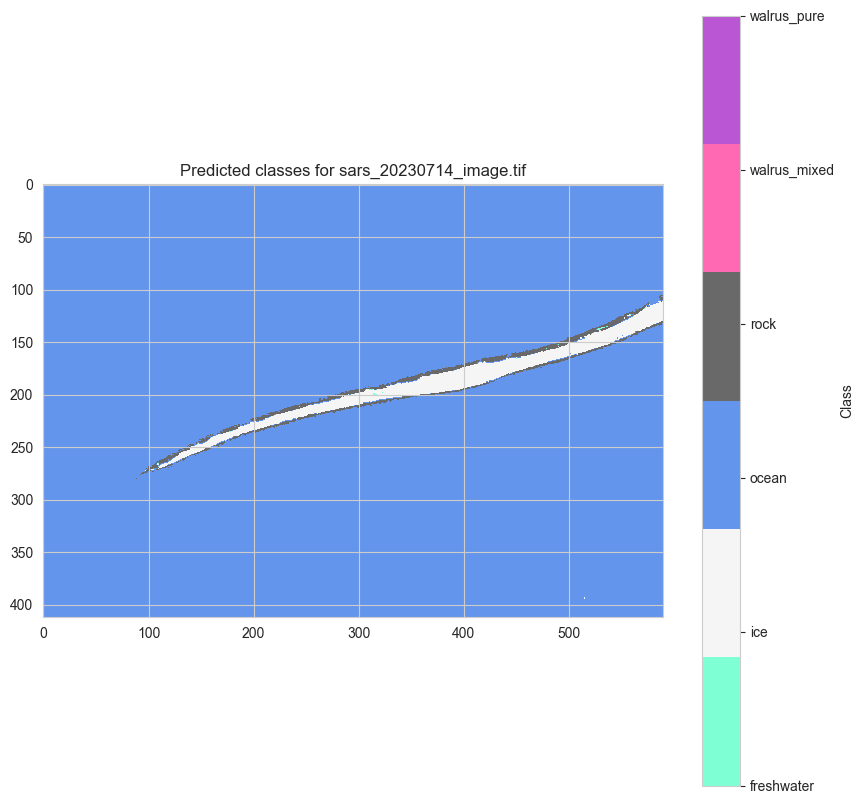

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


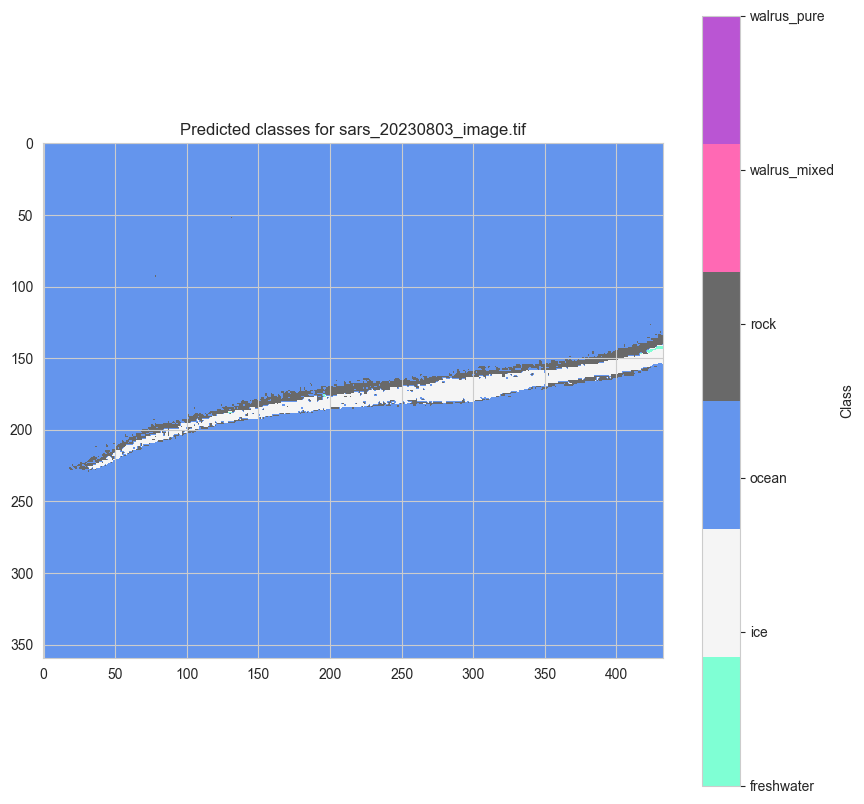

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


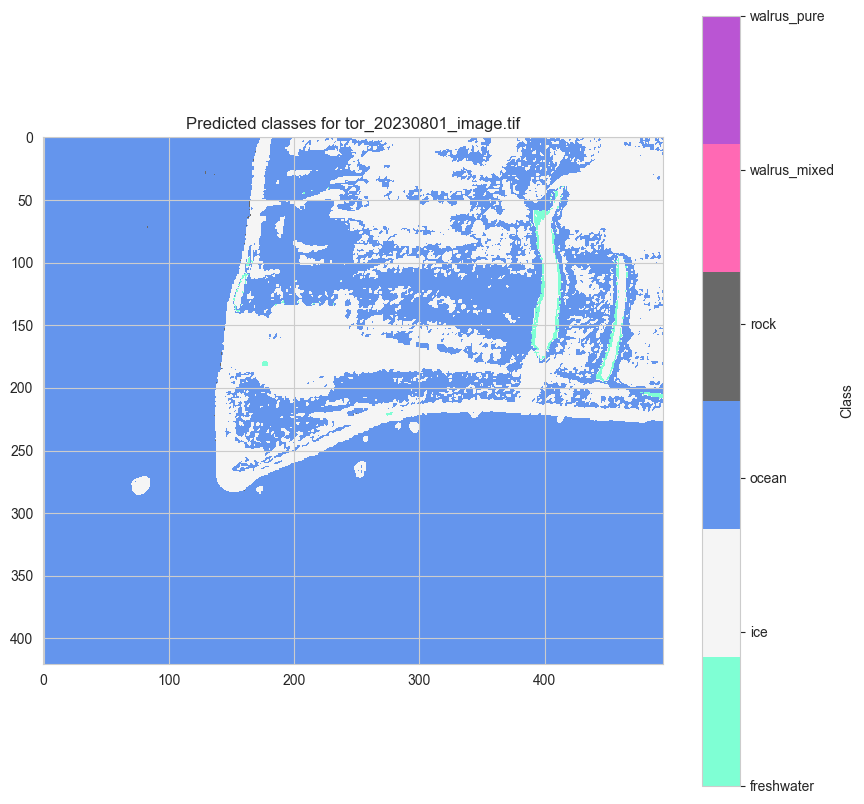

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


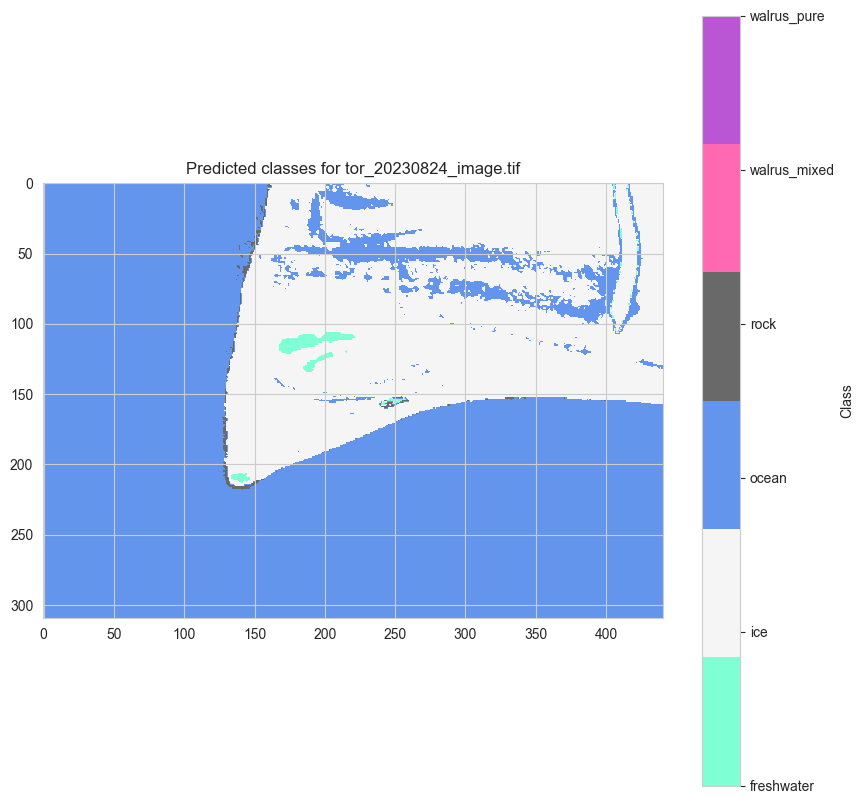

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


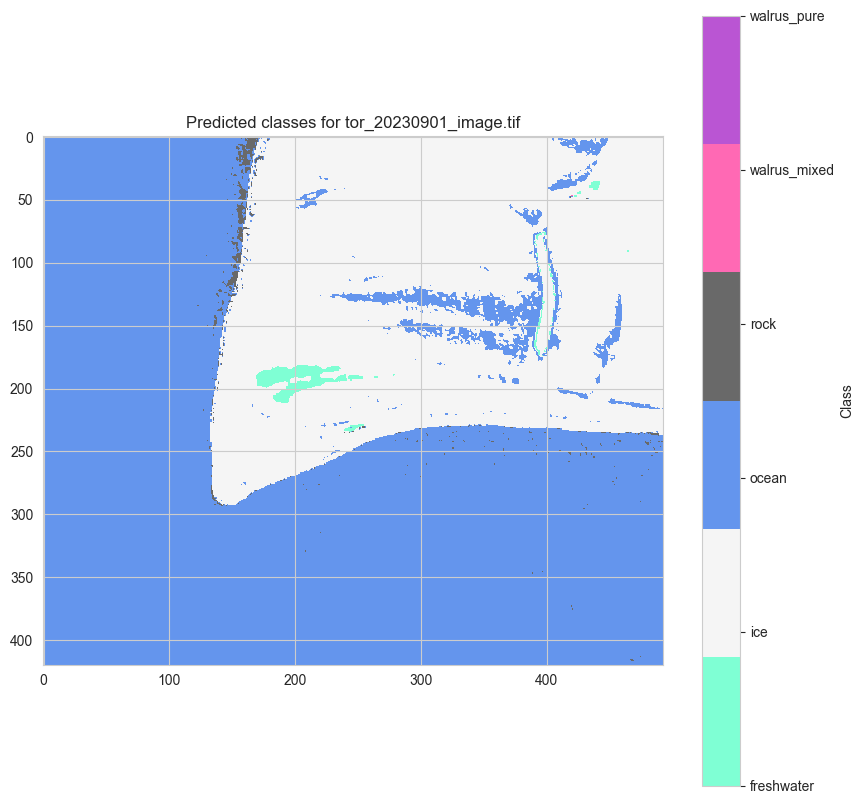

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


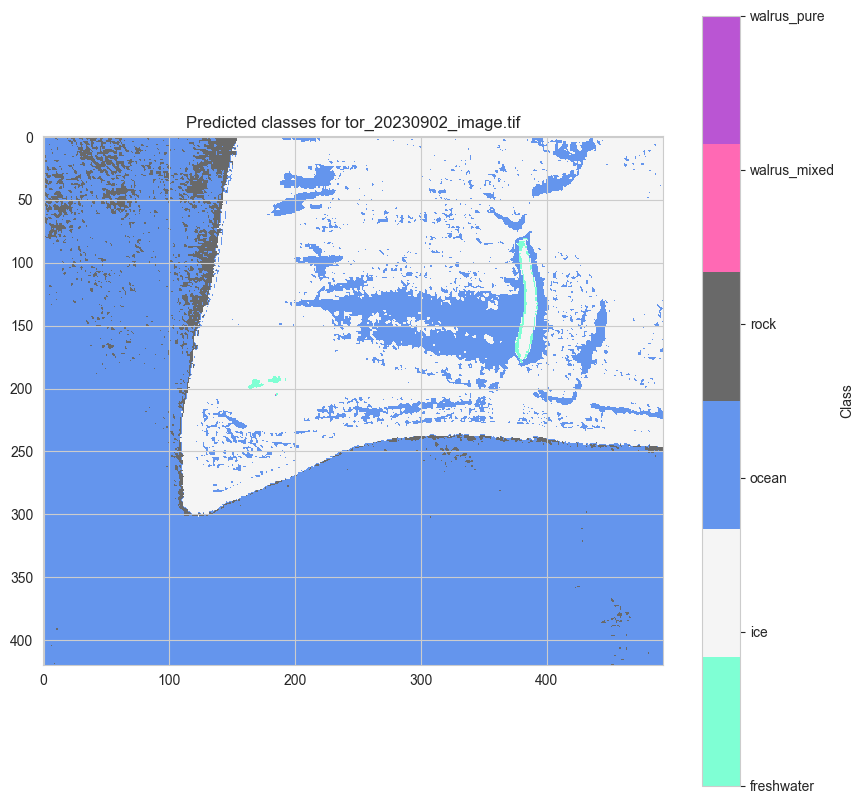

In [30]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

# Predict classes for images with attached shapefiles
predicted_images = {}
for image_path in file_pairs.keys():
    predicted_images[image_path] = predict_image(image_path, ensemble_model)

# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels([le.classes_[i] for i in range(len(le.classes_))])
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [ ]:
# Load the saved model
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

# Predict classes for unlabeled images
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels([le.inverse_transform([i])[0] for i in np.unique(predicted_image)])
    
    plt.show()


In [1]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import geometry_mask
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, precision_recall_curve
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(all_image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in all_image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(all_image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs, max_images=5):
    features = []
    labels = []
    image_name = []
    count = 0

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        if count >= max_images:
            break
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)
        count += 1

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
}) 
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Print class distribution before SMOTE
print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())

# Print island distribution before SMOTE
print("Island distribution before SMOTE:")
print(train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).value_counts())

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy={
    le.transform(['walrus_pure'])[0]: 500,  # example value, adjust as needed
    le.transform(['walrus_mixed'])[0]: 700  # example value, adjust as needed
}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Print island distribution after SMOTE
resampled_df = pd.DataFrame(X_resampled, columns=train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).columns)
resampled_df['encoded_labels'] = y_resampled
resampled_df['image_name'] = np.random.choice(train_df['image_name'], size=len(y_resampled))  # Simulate island distribution

print("Island distribution after SMOTE:")
print(resampled_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).value_counts())

# Apply undersampling if needed
rus = RandomUnderSampler(sampling_strategy={
    le.transform(['rock'])[0]: 5000,       # example value, adjust as needed
    le.transform(['ice'])[0]: 10000,       # example value, adjust as needed
    le.transform(['ocean'])[0]: 20000,     # example value, adjust as needed
    le.transform(['freshwater'])[0]: 5000  # example value, adjust as needed
}, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

# Print class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_resampled).value_counts())

# Feature scaling
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)  # Use the same scaler for the test set


Class distribution before SMOTE:
2    295211
1    166330
0     27808
3      7433
4       238
5        56
Name: count, dtype: int64
Island distribution before SMOTE:
image_name
buch    443079
moff     53997
Name: count, dtype: int64
Class distribution after SMOTE:
2    295211
1    166330
0     27808
3      7433
4       700
5       500
Name: count, dtype: int64
Island distribution after SMOTE:
image_name
buch    443934
moff     54048
Name: count, dtype: int64
Class distribution after undersampling:
2    20000
1    10000
0     5000
3     5000
4      700
5      500
Name: count, dtype: int64


In [3]:
# Ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_resampled, y_resampled)

# Save the ensemble model
model_filename = "ensemble_model.joblib"
joblib.dump(ensemble_model, model_filename)
print(f"Model saved as {model_filename}")
model_filename = "RF_allislands0207.joblib"


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model saved as ensemble_model.joblib


Accuracy: 0.9752633400123925
Precision: 0.9779260500696669
Recall: 0.9752633400123925
F1 Score: 0.9761806751495702
Cohen's Kappa: 0.9538862955242433

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.80      0.90      0.85      6953
         ice       0.98      0.96      0.97     41582
       ocean       1.00      0.99      1.00     73803
        rock       0.72      0.92      0.81      1858
walrus_mixed       0.33      0.53      0.40        59
 walrus_pure       0.17      0.21      0.19        14

    accuracy                           0.98    124269
   macro avg       0.67      0.75      0.70    124269
weighted avg       0.98      0.98      0.98    124269


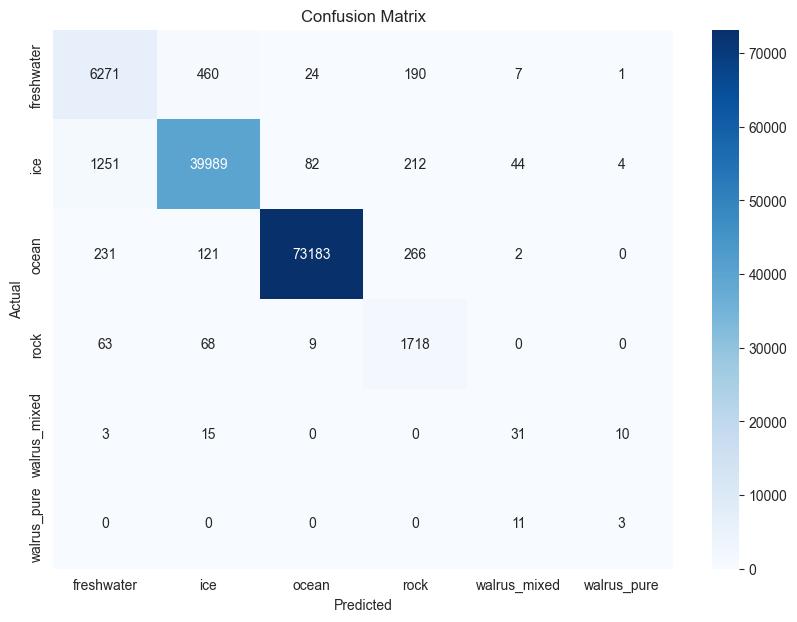

ValueError: multiclass format is not supported

In [6]:
# Evaluate the ensemble model
y_pred = ensemble_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the Precision-Recall Curve
y_proba = ensemble_model.predict_proba(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])  # assuming binary classification for precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [7]:
# Define a color map for the labels
class_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

Labels present in buch_20230714_image.tif: ['walrus_mixed', 'walrus_pure']


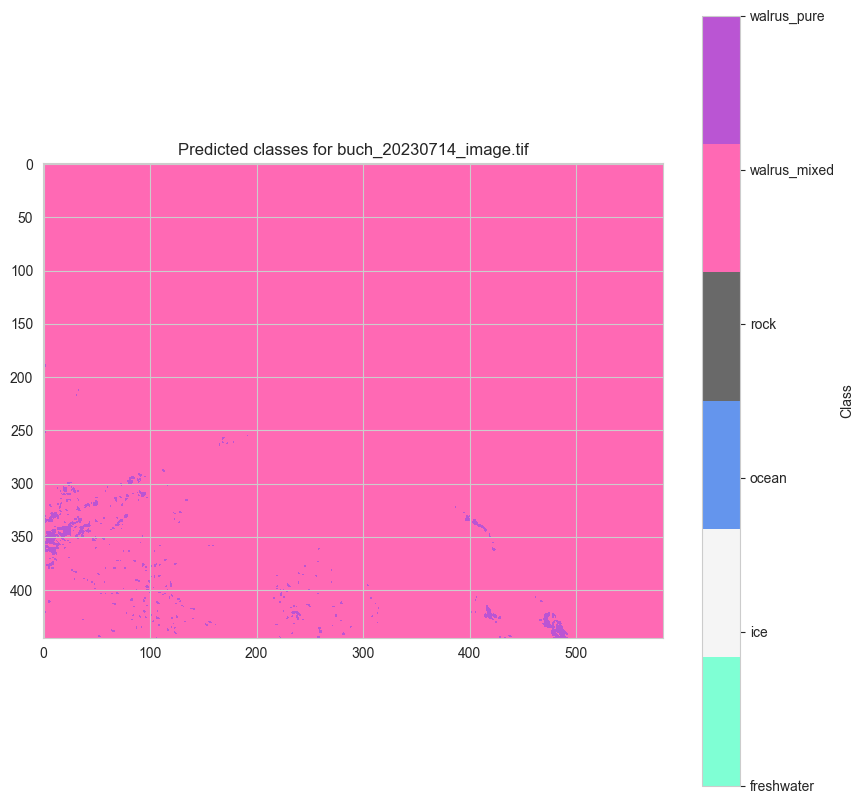

Labels present in buch_20230720_image.tif: ['walrus_mixed', 'walrus_pure']


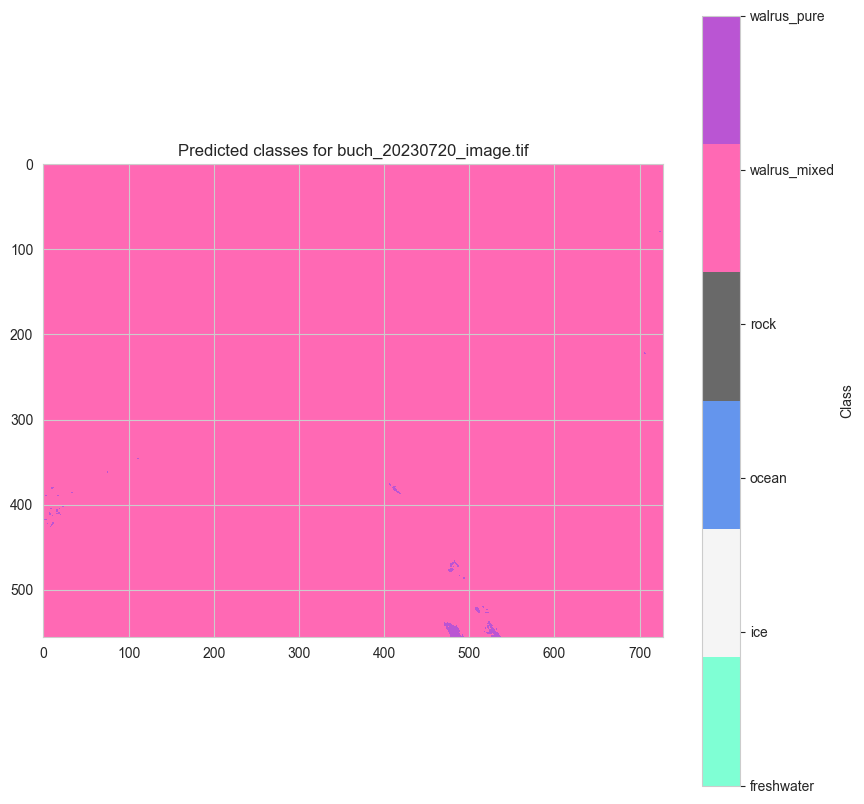

Labels present in buch_20230731_image.tif: ['walrus_mixed', 'walrus_pure']


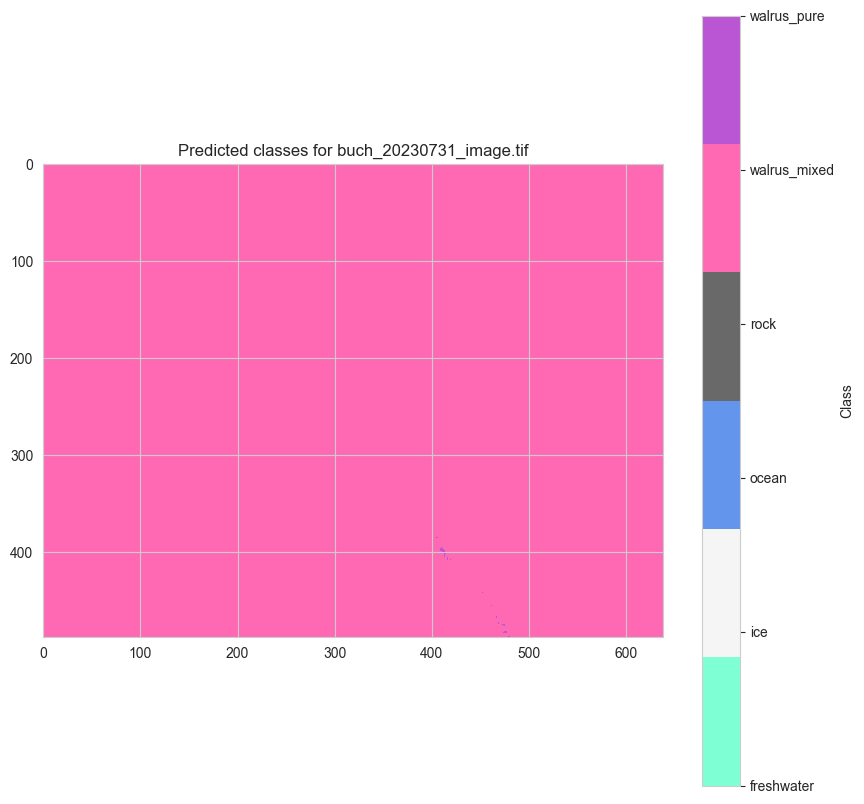

Labels present in buch_20230923_image.tif: ['walrus_mixed', 'walrus_pure']


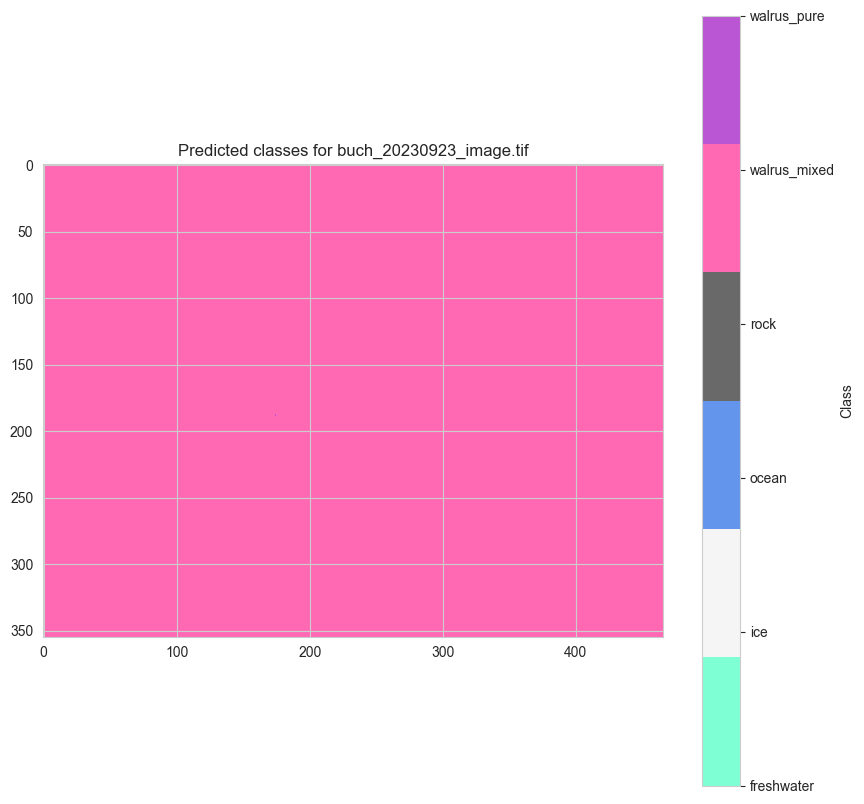

Labels present in moff_20230717_image.tif: ['walrus_mixed', 'walrus_pure']


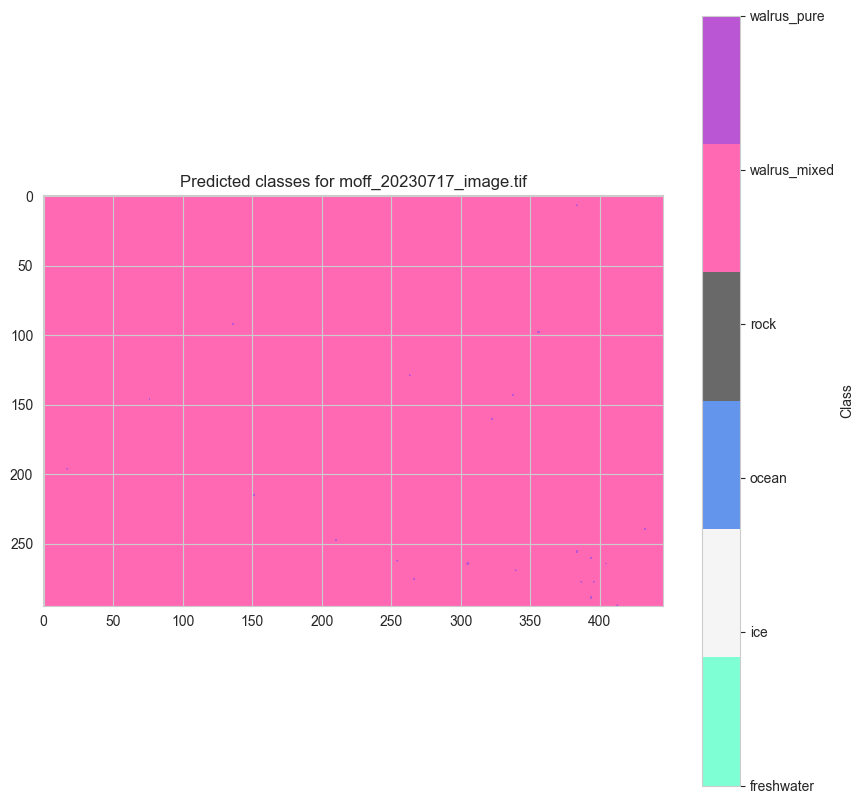

In [9]:
cmap = plt.cm.colors.ListedColormap([class_colors[cls] for cls in le.classes_])

def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = image.reshape((image.shape[0], -1)).T  # Reshape for prediction
    predictions = model.predict(features)
    predicted_image = predictions.reshape((image.shape[1], image.shape[2]))
    return predicted_image

# Example visualization of training images
predicted_images = {}
for image_path in image_paths[:5]:  # Limiting to first 5 images for example
    predicted_images[image_path] = predict_image(image_path, ensemble_model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels([le.classes_[i] for i in range(len(le.classes_))])
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

In [ ]:
# Load the saved model
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

# Predict classes for unlabeled images
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels([le.inverse_transform([i])[0] for i in np.unique(predicted_image)])
    
    plt.show()


In [ ]:
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = image.reshape((image.shape[0], -1)).T  # Reshape for prediction
    predictions = model.predict(features)
    predicted_image = predictions.reshape((image.shape[1], image.shape[2]))
    return predicted_image

# Example visualization of training images
predicted_images = {}
for image_path in image_paths[:5]:  # Limiting to first 5 images for example
    predicted_images[image_path] = predict_image(image_path, model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap='tab10', vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [ ]:
# Load the saved model
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

# Predict classes for unlabeled images
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap='tab10', vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()
